In [1]:
import warnings
warnings.filterwarnings("ignore")

import os, re
import copy
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from razdel import tokenize
import pymorphy2
from nltk.corpus import stopwords

pd.set_option('display.max_colwidth', None)

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


In [3]:
stopword_ru = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()

token_transform = get_tokenizer("spacy", language="ru_core_news_sm")

In [41]:
data = pd.read_excel("feedbacks_summer.xls", parse_dates=["Date"]).sort_values("Date")
data.head()

# we will solve classification task as ratings are provided as descrete values

,Rating,Content,Date
20658,5,Сбербанк бомбовая компания на сегодняшний день. Лидер банков.!! Держитесь в том же духе.,2017-06-01
20634,5,"Недавно пользуюсь, но то, что я использовал, работает отлично.",2017-06-01
20633,5,все отлично!,2017-06-01
20632,2,"Уважаемые разработчики, после последнего обновления я не могу зайти в приложение, зеленая полоска зависает на инициализации антивируса. У меня хонор 8 или вы теперь все сделали только для самсунгов? Когда вы обратите внимание на мои отзывы, я уже пишу вам ТРЕТИЙ раз!",2017-06-01
20631,2,"Что вообще случилось после последнего обновления? Инициализация интивируса очень очень оооочень долгая и с момента обновления ни разу я не дождалась окончания этой инициализации и соответственно ни разу не зашла в приложение! Было плохо,стало еще хуже!",2017-06-01


In [5]:
data["Rating"].value_counts()

5    14586
1     2276
4     2138
3      911
2      748
Name: Rating, dtype: int64

In [42]:
data["month"] = data["Date"].dt.month
data["day"] = data["Date"].dt.day

data.drop("Date", axis=1, inplace=True)

In [43]:
def clean_text(text, tokenized=False):
    
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", ' ', str(text))
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())

    text = re.sub("\W+", ' ', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    
    if not isinstance(text, str):
        text = str(text)
    
    if tokenized:
        tokens = list(tokenize(text))
        words = [_.text for _ in tokens]
        words = [w for w in words if w not in stopword_ru]
        return " ".join(words)
    
    return text

cache = {}

def lemmatization(text):

    if not isinstance(text, str):
        text = str(text)

    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-':
            w = w[1:]
        if len(w)>1:
            if w in cache:
                words_lem.append(cache[w])
            else:
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru]
    
    return " ".join(words_lem_without_stopwords)

In [44]:
# clean and split

data["Content"] = data["Content"].apply(lambda x: clean_text(x, tokenized=False))  # set True for tranformers
data["Content"] = data["Content"].apply(lambda x: lemmatization(x))  # comment for transformers

<AxesSubplot:>

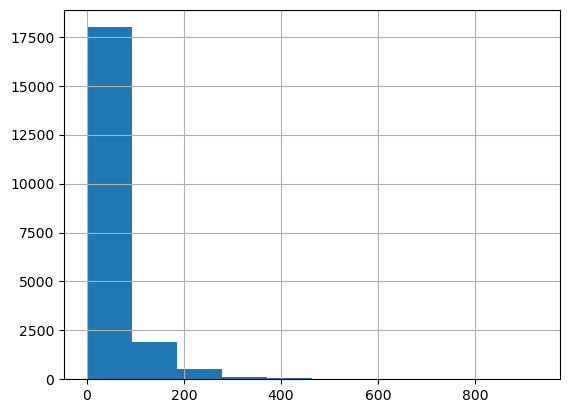

In [45]:
data["Content"].str.len().hist()

In [46]:
data = data[~(data["Content"].str.len() == 0)]
data["Rating"] = data["Rating"] - 1

In [47]:
def yield_tokens(data_iter):

    for data_sample in data_iter:
        yield token_transform(data_sample[0])  # [1] - label

In [48]:
PAD_IDX, UNK_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ["<pad>", "<unk>", "<bos>", "<eos>"]

In [49]:
# split by date? not so huge period -> just shuffle

train, valid = train_test_split(data, test_size=0.1, shuffle=True, stratify=data["Rating"], random_state=42)
valid, test = train_test_split(valid, test_size=500, shuffle=True, random_state=42)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [50]:
class_counts = train["Rating"].value_counts().to_list()
num_samples = sum(class_counts)
labels = train["Rating"].values - 1

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

In [51]:
# Dataset

class TextDataset(Dataset):
    def __init__(self, data, max_len=64):
        self.data = data
        self.max_len = max_len

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ix):
        row = self.data.iloc[ix].squeeze()
        text = row["Content"]
        label = row["Rating"]
        
        return text, label

    def collate_fn(self, batch):
        texts, labels = list(zip(*batch))
        
        text_batch = torch.zeros((len(texts), self.max_len)).fill_(PAD_IDX).long()
        
        # constant max_length
        for i in range(len(texts)):
            sample = text_transform(texts[i])[:self.max_len]
            text_batch[i, :len(sample)] = sample

        # text_batch = pad_sequence(text_batch, padding_value=PAD_IDX, batch_first=True).to(device) # pads only to current max
        
        labels = torch.cat([torch.tensor(label).unsqueeze(0) for label in labels]).to(device)
        return text_batch.to(device), labels

In [52]:
data_iter = TextDataset(data)

vocabulary = build_vocab_from_iterator(yield_tokens(data_iter),  # define Dataset
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)
vocabulary.set_default_index(UNK_IDX)

In [53]:
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def tensor_transform(token_ids, drop_specials=True):
    if drop_specials:
        return torch.tensor(token_ids)
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

text_transform = sequential_transforms(token_transform,
                                       vocabulary,
                                       tensor_transform)

In [54]:
train_ds = TextDataset(train)
valid_ds = TextDataset(valid)
test_ds = TextDataset(test)

train_dataloader = DataLoader(train_ds, batch_size=128, shuffle=True, collate_fn=train_ds.collate_fn)
# train_dataloader = DataLoader(train_ds, batch_size=128, shuffle=False, sampler=sampler, collate_fn=train_ds.collate_fn)
valid_dataloader = DataLoader(valid_ds, batch_size=128, collate_fn=valid_ds.collate_fn)
test_dataloader = DataLoader(test_ds, batch_size=64, collate_fn=test_ds.collate_fn)

In [55]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path='model.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            if model is not None:
                checkpoint = {
                    'model': model,
                }
                torch.save(checkpoint, self.path)
                print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True
                
def calc_accuracy(y_pred, y_true):
    return (y_true == torch.max(y_pred, 1)[1]).float().mean()


class FocalLoss(nn.Module):
    """ 
    https://github.com/AdeelH/pytorch-multi-class-focal-loss/blob/master/focal_loss.py
    
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """
    def __init__(self, *args, 
                 alpha: torch.Tensor = None, 
                 gamma: float = 2.0, 
                 reduction: str = 'mean',
                 ignore_index: int = -100,
                 **kwargs
                 ):
        """
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 2.0
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(
                'Reduction must be one of: "mean", "sum", "none".')

        super(FocalLoss, self).__init__(*args, **kwargs)
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(
            weight=alpha, reduction='none', ignore_index=ignore_index)

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        if x.ndim > 2:
            c = x.shape[1]  # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            y = y.view(-1)  # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
        
        y = y.long()
        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return torch.tensor(0.)
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt) (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss

In [20]:
def train_one_batch(data, model, criterion, optimizer):
    model.train()
    texts, labels = data
    optimizer.zero_grad()
    output = model(texts)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = calc_accuracy(output, labels)
    return loss.item(), accuracy.item()


@torch.no_grad()
def validate_one_batch(data, model, criterion):
    model.eval()
    texts, labels = data
    
    out = model(texts)
    loss = criterion(out, labels)
    
    accuracy = calc_accuracy(out, labels)
    
    return loss.item(), accuracy.item()

In [21]:
def run(model, epochs=40, print_freq=50):

    for epoch in range(1, epochs+1):

        train_loss, train_accs = [], []
        for step, batch in enumerate(train_dataloader, 1):
            time_1 = time.time()

            loss, accuracy = train_one_batch(batch, model, criterion, optimizer)

            train_loss.append(loss)
            train_accs.append(accuracy)

            if step % print_freq == 0:
                print('epoch:', epoch, 
                      '\tstep:', step, '/', len(train_dataloader),
                      '\ttrain loss:', '{:.4f}'.format(loss),
                      '\ttrain accuracy:','{:.4f}'.format(accuracy),
                      '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_freq), 's')

        valid_loss, valid_accs = [], []
        for step, batch in enumerate(tqdm(valid_dataloader)):
            loss, accuracy = validate_one_batch(batch, model, criterion)

            valid_loss.append(loss)
            valid_accs.append(accuracy)

        print('epoch:', epoch, '/', epochs,
              '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
              '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
              '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
              '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))

        stopper(np.mean(valid_loss), model)
        if stopper.early_stop:
            checkpoint = torch.load("model.pth", map_location=device)
            model = checkpoint['model']
            break
        scheduler.step(np.mean(valid_loss))

    test_loss, test_accs = [], []
    for step, batch in enumerate(tqdm(test_dataloader)):
        loss, accuracy = validate_one_batch(batch, model, criterion)

        test_loss.append(loss)
        test_accs.append(accuracy)

    print('\ttest loss:', '{:.4f}'.format(np.mean(test_loss)),
          '\ttest accuracy', '{:.4f}'.format(np.mean(test_accs)),)

**Models**

* CNN
* LSTM 
* LSTM-CNN
* Transformer

**CNN**

In [22]:
class CNNModel(nn.Module):
    def __init__(self, hidden_dim, vocab_size, num_classes=5, dropout=0.1, **kwargs):
        super(CNNModel ,self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)  #, padding_idx=PAD_IDX)  # default = 0
        self.conv1 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1)
        
        self.cconv1 = nn.Conv1d(hidden_dim, hidden_dim//4, kernel_size=1, padding=0)
        self.cconv2 = nn.Conv1d(hidden_dim, hidden_dim//4, kernel_size=2, padding=1)
        self.cconv3 = nn.Conv1d(hidden_dim, hidden_dim//4, kernel_size=3, padding=1)
        self.cconv4 = nn.Conv1d(hidden_dim, hidden_dim//4, kernel_size=5, padding=2)
        self.cbatch = nn.BatchNorm1d(hidden_dim)
        
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(hidden_dim*2, hidden_dim*2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_dim*2, hidden_dim*4, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(hidden_dim*4, hidden_dim*4, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        
        self.reducer = nn.Linear(hidden_dim*4, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.contiguous().permute(0,2,1)  # [B, SEQ_LEN, hidden] -> [B, hidden, SEQ_LEN] to slide over sequence for n-gramms
        
        # x = self.conv1(x)  # comment to simplify
        # x = F.relu(x)
        
        in_x1 = self.cconv1(x)
        in_x2 = self.cconv1(x)
        in_x3 = self.cconv1(x)
        in_x4 = self.cconv1(x)
        in_x = torch.cat([in_x1, in_x2, in_x3, in_x4], dim=1)
        # in_x = self.cbatch(x)
        in_x = F.relu(in_x)
        
        x = self.conv2(in_x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv5(x)
        x = F.relu(x)
        # x = self.pool(x)
        x = torch.max(x, dim=2)[0]  # obtain max n-gramm info
        # x = x.contiguous().view(x.size(0), -1)
        x = self.reducer(x)
        x = F.relu(x)
        
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [23]:
model = CNNModel(hidden_dim=64, vocab_size=len(vocabulary), dropout=0.3, num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.1)
stopper = EarlyStopping(patience=4)

In [24]:
run(model)

epoch: 1 	step: 50 / 144 	train loss: 0.9045 	train accuracy: 0.6562 	time: 0.0121 s
epoch: 1 	step: 100 / 144 	train loss: 0.7420 	train accuracy: 0.7422 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.61it/s]


epoch: 1 / 40 	train loss: 0.8374 	valid loss: 0.7158 	train accuracy 0.7188 	valid accuracy 0.7370
epoch: 2 	step: 50 / 144 	train loss: 0.6727 	train accuracy: 0.7656 	time: 0.7836 s
epoch: 2 	step: 100 / 144 	train loss: 0.6946 	train accuracy: 0.7734 	time: 0.7805 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.90it/s]


epoch: 2 / 40 	train loss: 0.6877 	valid loss: 0.6939 	train accuracy 0.7616 	valid accuracy 0.7461
Model saved to: model.pth
epoch: 3 	step: 50 / 144 	train loss: 0.6508 	train accuracy: 0.7734 	time: 0.7779 s
epoch: 3 	step: 100 / 144 	train loss: 0.7221 	train accuracy: 0.7422 	time: 0.5004 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.11it/s]


epoch: 3 / 40 	train loss: 0.6550 	valid loss: 0.6894 	train accuracy 0.7710 	valid accuracy 0.7520
Model saved to: model.pth
epoch: 4 	step: 50 / 144 	train loss: 0.5184 	train accuracy: 0.8203 	time: 0.0000 s
epoch: 4 	step: 100 / 144 	train loss: 0.6480 	train accuracy: 0.7734 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.10it/s]


epoch: 4 / 40 	train loss: 0.6260 	valid loss: 0.6890 	train accuracy 0.7798 	valid accuracy 0.7546
Model saved to: model.pth
epoch: 5 	step: 50 / 144 	train loss: 0.5903 	train accuracy: 0.7656 	time: 0.7785 s
epoch: 5 	step: 100 / 144 	train loss: 0.6048 	train accuracy: 0.7891 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.27it/s]


epoch: 5 / 40 	train loss: 0.6043 	valid loss: 0.6846 	train accuracy 0.7850 	valid accuracy 0.7591
Model saved to: model.pth
epoch: 6 	step: 50 / 144 	train loss: 0.6297 	train accuracy: 0.7578 	time: 0.6001 s
epoch: 6 	step: 100 / 144 	train loss: 0.5482 	train accuracy: 0.8359 	time: 1.0448 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.33it/s]


epoch: 6 / 40 	train loss: 0.5797 	valid loss: 0.6955 	train accuracy 0.7923 	valid accuracy 0.7539
INFO: Early stopping counter 1 of 4
epoch: 7 	step: 50 / 144 	train loss: 0.4928 	train accuracy: 0.8438 	time: 0.4500 s
epoch: 7 	step: 100 / 144 	train loss: 0.6035 	train accuracy: 0.7891 	time: 0.6423 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.19it/s]


epoch: 7 / 40 	train loss: 0.5549 	valid loss: 0.6937 	train accuracy 0.8004 	valid accuracy 0.7507
INFO: Early stopping counter 2 of 4
epoch: 8 	step: 50 / 144 	train loss: 0.6115 	train accuracy: 0.7734 	time: 0.4995 s
epoch: 8 	step: 100 / 144 	train loss: 0.6373 	train accuracy: 0.7734 	time: 0.4500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.30it/s]


epoch: 8 / 40 	train loss: 0.5378 	valid loss: 0.7281 	train accuracy 0.8070 	valid accuracy 0.7552
INFO: Early stopping counter 3 of 4
epoch: 9 	step: 50 / 144 	train loss: 0.6171 	train accuracy: 0.7578 	time: 0.4998 s
epoch: 9 	step: 100 / 144 	train loss: 0.4824 	train accuracy: 0.8359 	time: 0.7896 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.13it/s]


epoch: 9 / 40 	train loss: 0.4933 	valid loss: 0.7472 	train accuracy 0.8238 	valid accuracy 0.7461
INFO: Early stopping counter 4 of 4
INFO: Early stopping


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.41it/s]

	test loss: 0.6045 	test accuracy 0.7691


**Bidirectional LSTM**

In [25]:
class BiLSTM(nn.Module):
    def __init__(self, hidden_dim, vocab_size, num_classes=5, dropout=0.1, num_layers=2, **kwargs):
        super(BiLSTM, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(input_size=hidden_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=dropout,
                            bidirectional=True)
        self.dropout = nn.Dropout(p=dropout)
        self.fc_mid = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc_out = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        
        # contains the output features (h_t) from the last layer of the LSTM, for each t: [B, SEQ, hidden * bidirect]
        x, _ = self.lstm(x)
        
        avg_pool = torch.mean(x, dim=1)
        max_pool = torch.max(x, dim=1)[0]
        
        x = torch.cat((avg_pool, max_pool), dim=1)
        
        x = F.relu(self.fc_mid(self.dropout(x)))

        x = self.fc_out(x)
        return x

In [26]:
model = BiLSTM(hidden_dim=64, vocab_size=len(vocabulary), dropout=0.3, num_layers=1).to(device)

criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=4)

In [27]:
run(model)

epoch: 1 	step: 50 / 144 	train loss: 1.1259 	train accuracy: 0.6797 	time: 0.2998 s
epoch: 1 	step: 100 / 144 	train loss: 0.7066 	train accuracy: 0.8125 	time: 0.7785 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.28it/s]


epoch: 1 / 40 	train loss: 1.0912 	valid loss: 0.9204 	train accuracy 0.6523 	valid accuracy 0.6986
epoch: 2 	step: 50 / 144 	train loss: 0.8760 	train accuracy: 0.7031 	time: 0.4356 s
epoch: 2 	step: 100 / 144 	train loss: 0.7834 	train accuracy: 0.7422 	time: 0.7821 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.55it/s]


epoch: 2 / 40 	train loss: 0.8635 	valid loss: 0.8532 	train accuracy 0.7133 	valid accuracy 0.7207
Model saved to: model.pth
epoch: 3 	step: 50 / 144 	train loss: 0.8053 	train accuracy: 0.7578 	time: 0.5502 s
epoch: 3 	step: 100 / 144 	train loss: 0.7679 	train accuracy: 0.7266 	time: 1.1443 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.63it/s]


epoch: 3 / 40 	train loss: 0.8092 	valid loss: 0.8205 	train accuracy 0.7278 	valid accuracy 0.7253
Model saved to: model.pth
epoch: 4 	step: 50 / 144 	train loss: 0.8460 	train accuracy: 0.7109 	time: 0.5004 s
epoch: 4 	step: 100 / 144 	train loss: 0.7683 	train accuracy: 0.7578 	time: 0.5000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.56it/s]


epoch: 4 / 40 	train loss: 0.7724 	valid loss: 0.7859 	train accuracy 0.7351 	valid accuracy 0.7337
Model saved to: model.pth
epoch: 5 	step: 50 / 144 	train loss: 0.6739 	train accuracy: 0.7656 	time: 0.5000 s
epoch: 5 	step: 100 / 144 	train loss: 0.6718 	train accuracy: 0.7656 	time: 0.7813 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.61it/s]


epoch: 5 / 40 	train loss: 0.7373 	valid loss: 0.7558 	train accuracy 0.7447 	valid accuracy 0.7350
Model saved to: model.pth
epoch: 6 	step: 50 / 144 	train loss: 0.7116 	train accuracy: 0.7266 	time: 0.5000 s
epoch: 6 	step: 100 / 144 	train loss: 0.6878 	train accuracy: 0.7422 	time: 0.7812 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.21it/s]


epoch: 6 / 40 	train loss: 0.7159 	valid loss: 0.7391 	train accuracy 0.7510 	valid accuracy 0.7376
Model saved to: model.pth
epoch: 7 	step: 50 / 144 	train loss: 0.6344 	train accuracy: 0.7969 	time: 0.0000 s
epoch: 7 	step: 100 / 144 	train loss: 0.7247 	train accuracy: 0.7656 	time: 0.5500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.84it/s]


epoch: 7 / 40 	train loss: 0.6942 	valid loss: 0.7270 	train accuracy 0.7581 	valid accuracy 0.7448
Model saved to: model.pth
epoch: 8 	step: 50 / 144 	train loss: 0.6669 	train accuracy: 0.7969 	time: 0.5000 s
epoch: 8 	step: 100 / 144 	train loss: 0.6293 	train accuracy: 0.7812 	time: 0.5500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.37it/s]


epoch: 8 / 40 	train loss: 0.6855 	valid loss: 0.7223 	train accuracy 0.7593 	valid accuracy 0.7448
Model saved to: model.pth
epoch: 9 	step: 50 / 144 	train loss: 0.6407 	train accuracy: 0.7734 	time: 0.0000 s
epoch: 9 	step: 100 / 144 	train loss: 0.6717 	train accuracy: 0.7812 	time: 0.3814 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.72it/s]


epoch: 9 / 40 	train loss: 0.6792 	valid loss: 0.7158 	train accuracy 0.7606 	valid accuracy 0.7467
Model saved to: model.pth
epoch: 10 	step: 50 / 144 	train loss: 0.8016 	train accuracy: 0.6953 	time: 0.7807 s
epoch: 10 	step: 100 / 144 	train loss: 0.5195 	train accuracy: 0.8359 	time: 0.6945 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.69it/s]


epoch: 10 / 40 	train loss: 0.6673 	valid loss: 0.7093 	train accuracy 0.7652 	valid accuracy 0.7467
Model saved to: model.pth
epoch: 11 	step: 50 / 144 	train loss: 0.7045 	train accuracy: 0.7734 	time: 0.4996 s
epoch: 11 	step: 100 / 144 	train loss: 0.6218 	train accuracy: 0.7656 	time: 0.7812 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.58it/s]


epoch: 11 / 40 	train loss: 0.6616 	valid loss: 0.7041 	train accuracy 0.7672 	valid accuracy 0.7461
Model saved to: model.pth
epoch: 12 	step: 50 / 144 	train loss: 0.7452 	train accuracy: 0.7422 	time: 0.4996 s
epoch: 12 	step: 100 / 144 	train loss: 0.6858 	train accuracy: 0.7812 	time: 0.4499 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 63.67it/s]


epoch: 12 / 40 	train loss: 0.6605 	valid loss: 0.6992 	train accuracy 0.7680 	valid accuracy 0.7520
Model saved to: model.pth
epoch: 13 	step: 50 / 144 	train loss: 0.6867 	train accuracy: 0.7344 	time: 0.9908 s
epoch: 13 	step: 100 / 144 	train loss: 0.6519 	train accuracy: 0.7656 	time: 0.7781 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.73it/s]


epoch: 13 / 40 	train loss: 0.6538 	valid loss: 0.6962 	train accuracy 0.7687 	valid accuracy 0.7493
Model saved to: model.pth
epoch: 14 	step: 50 / 144 	train loss: 0.7023 	train accuracy: 0.7500 	time: 0.0000 s
epoch: 14 	step: 100 / 144 	train loss: 0.5440 	train accuracy: 0.8047 	time: 0.7814 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.80it/s]


epoch: 14 / 40 	train loss: 0.6466 	valid loss: 0.6931 	train accuracy 0.7720 	valid accuracy 0.7526
Model saved to: model.pth
epoch: 15 	step: 50 / 144 	train loss: 0.5633 	train accuracy: 0.8125 	time: 0.5000 s
epoch: 15 	step: 100 / 144 	train loss: 0.6663 	train accuracy: 0.7734 	time: 0.5000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.26it/s]


epoch: 15 / 40 	train loss: 0.6410 	valid loss: 0.6901 	train accuracy 0.7729 	valid accuracy 0.7520
Model saved to: model.pth
epoch: 16 	step: 50 / 144 	train loss: 0.7809 	train accuracy: 0.7422 	time: 0.7803 s
epoch: 16 	step: 100 / 144 	train loss: 0.6396 	train accuracy: 0.7656 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.13it/s]


epoch: 16 / 40 	train loss: 0.6388 	valid loss: 0.6877 	train accuracy 0.7738 	valid accuracy 0.7578
Model saved to: model.pth
epoch: 17 	step: 50 / 144 	train loss: 0.5794 	train accuracy: 0.7891 	time: 0.5499 s
epoch: 17 	step: 100 / 144 	train loss: 0.7630 	train accuracy: 0.7031 	time: 0.2070 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.99it/s]


epoch: 17 / 40 	train loss: 0.6313 	valid loss: 0.6863 	train accuracy 0.7752 	valid accuracy 0.7598
Model saved to: model.pth
epoch: 18 	step: 50 / 144 	train loss: 0.6004 	train accuracy: 0.7656 	time: 0.5005 s
epoch: 18 	step: 100 / 144 	train loss: 0.5889 	train accuracy: 0.8281 	time: 0.4999 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.63it/s]


epoch: 18 / 40 	train loss: 0.6305 	valid loss: 0.6812 	train accuracy 0.7773 	valid accuracy 0.7591
Model saved to: model.pth
epoch: 19 	step: 50 / 144 	train loss: 0.6606 	train accuracy: 0.7500 	time: 0.0000 s
epoch: 19 	step: 100 / 144 	train loss: 0.6259 	train accuracy: 0.7578 	time: 0.7840 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.34it/s]


epoch: 19 / 40 	train loss: 0.6286 	valid loss: 0.6797 	train accuracy 0.7780 	valid accuracy 0.7591
Model saved to: model.pth
epoch: 20 	step: 50 / 144 	train loss: 0.5608 	train accuracy: 0.8125 	time: 0.0000 s
epoch: 20 	step: 100 / 144 	train loss: 0.7083 	train accuracy: 0.7109 	time: 1.0400 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.69it/s]


epoch: 20 / 40 	train loss: 0.6197 	valid loss: 0.6783 	train accuracy 0.7786 	valid accuracy 0.7611
Model saved to: model.pth
epoch: 21 	step: 50 / 144 	train loss: 0.6066 	train accuracy: 0.7969 	time: 0.7813 s
epoch: 21 	step: 100 / 144 	train loss: 0.5466 	train accuracy: 0.7969 	time: 0.4508 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.26it/s]


epoch: 21 / 40 	train loss: 0.6132 	valid loss: 0.6771 	train accuracy 0.7842 	valid accuracy 0.7637
Model saved to: model.pth
epoch: 22 	step: 50 / 144 	train loss: 0.7339 	train accuracy: 0.7422 	time: 0.5000 s
epoch: 22 	step: 100 / 144 	train loss: 0.5021 	train accuracy: 0.8047 	time: 0.5001 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.81it/s]


epoch: 22 / 40 	train loss: 0.6103 	valid loss: 0.6762 	train accuracy 0.7809 	valid accuracy 0.7656
Model saved to: model.pth
epoch: 23 	step: 50 / 144 	train loss: 0.7490 	train accuracy: 0.7422 	time: 0.5000 s
epoch: 23 	step: 100 / 144 	train loss: 0.6490 	train accuracy: 0.7812 	time: 0.4499 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.02it/s]


epoch: 23 / 40 	train loss: 0.6041 	valid loss: 0.6746 	train accuracy 0.7860 	valid accuracy 0.7643
Model saved to: model.pth
epoch: 24 	step: 50 / 144 	train loss: 0.6166 	train accuracy: 0.7578 	time: 0.4997 s
epoch: 24 	step: 100 / 144 	train loss: 0.7780 	train accuracy: 0.7109 	time: 0.2566 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.63it/s]


epoch: 24 / 40 	train loss: 0.6024 	valid loss: 0.6715 	train accuracy 0.7860 	valid accuracy 0.7643
Model saved to: model.pth
epoch: 25 	step: 50 / 144 	train loss: 0.4580 	train accuracy: 0.8359 	time: 0.0000 s
epoch: 25 	step: 100 / 144 	train loss: 0.5669 	train accuracy: 0.8047 	time: 0.4996 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.94it/s]


epoch: 25 / 40 	train loss: 0.6008 	valid loss: 0.6708 	train accuracy 0.7886 	valid accuracy 0.7624
Model saved to: model.pth
epoch: 26 	step: 50 / 144 	train loss: 0.4827 	train accuracy: 0.8359 	time: 0.5000 s
epoch: 26 	step: 100 / 144 	train loss: 0.6875 	train accuracy: 0.7656 	time: 0.7777 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.40it/s]


epoch: 26 / 40 	train loss: 0.5968 	valid loss: 0.6676 	train accuracy 0.7886 	valid accuracy 0.7663
Model saved to: model.pth
epoch: 27 	step: 50 / 144 	train loss: 0.6324 	train accuracy: 0.7969 	time: 0.9915 s
epoch: 27 	step: 100 / 144 	train loss: 0.7517 	train accuracy: 0.7500 	time: 0.5000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.13it/s]


epoch: 27 / 40 	train loss: 0.5924 	valid loss: 0.6686 	train accuracy 0.7905 	valid accuracy 0.7643
INFO: Early stopping counter 1 of 4
epoch: 28 	step: 50 / 144 	train loss: 0.5536 	train accuracy: 0.8281 	time: 0.7813 s
epoch: 28 	step: 100 / 144 	train loss: 0.6279 	train accuracy: 0.7891 	time: 0.4993 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.85it/s]


epoch: 28 / 40 	train loss: 0.5923 	valid loss: 0.6648 	train accuracy 0.7920 	valid accuracy 0.7650
Model saved to: model.pth
epoch: 29 	step: 50 / 144 	train loss: 0.6045 	train accuracy: 0.7812 	time: 0.0000 s
epoch: 29 	step: 100 / 144 	train loss: 0.5919 	train accuracy: 0.7812 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.06it/s]


epoch: 29 / 40 	train loss: 0.5847 	valid loss: 0.6649 	train accuracy 0.7928 	valid accuracy 0.7663
INFO: Early stopping counter 1 of 4
epoch: 30 	step: 50 / 144 	train loss: 0.5496 	train accuracy: 0.8125 	time: 0.5002 s
epoch: 30 	step: 100 / 144 	train loss: 0.6211 	train accuracy: 0.7266 	time: 0.4995 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.51it/s]


epoch: 30 / 40 	train loss: 0.5814 	valid loss: 0.6648 	train accuracy 0.7930 	valid accuracy 0.7656
INFO: Early stopping counter 2 of 4
epoch: 31 	step: 50 / 144 	train loss: 0.6548 	train accuracy: 0.7812 	time: 1.1081 s
epoch: 31 	step: 100 / 144 	train loss: 0.5761 	train accuracy: 0.8047 	time: 0.4563 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.03it/s]


epoch: 31 / 40 	train loss: 0.5835 	valid loss: 0.6627 	train accuracy 0.7928 	valid accuracy 0.7637
Model saved to: model.pth
epoch: 32 	step: 50 / 144 	train loss: 0.4645 	train accuracy: 0.8672 	time: 0.7824 s
epoch: 32 	step: 100 / 144 	train loss: 0.7911 	train accuracy: 0.6953 	time: 0.5000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.42it/s]


epoch: 32 / 40 	train loss: 0.5811 	valid loss: 0.6612 	train accuracy 0.7938 	valid accuracy 0.7669
Model saved to: model.pth
epoch: 33 	step: 50 / 144 	train loss: 0.6997 	train accuracy: 0.7656 	time: 0.4499 s
epoch: 33 	step: 100 / 144 	train loss: 0.5192 	train accuracy: 0.8594 	time: 0.7812 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.47it/s]


epoch: 33 / 40 	train loss: 0.5771 	valid loss: 0.6639 	train accuracy 0.7961 	valid accuracy 0.7663
INFO: Early stopping counter 1 of 4
epoch: 34 	step: 50 / 144 	train loss: 0.5539 	train accuracy: 0.8047 	time: 0.4999 s
epoch: 34 	step: 100 / 144 	train loss: 0.5498 	train accuracy: 0.8125 	time: 1.0488 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.52it/s]


epoch: 34 / 40 	train loss: 0.5696 	valid loss: 0.6634 	train accuracy 0.7975 	valid accuracy 0.7656
INFO: Early stopping counter 2 of 4
epoch: 35 	step: 50 / 144 	train loss: 0.5966 	train accuracy: 0.7734 	time: 0.5496 s
epoch: 35 	step: 100 / 144 	train loss: 0.6726 	train accuracy: 0.7266 	time: 0.7782 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.80it/s]


epoch: 35 / 40 	train loss: 0.5659 	valid loss: 0.6626 	train accuracy 0.7987 	valid accuracy 0.7669
INFO: Early stopping counter 3 of 4
epoch: 36 	step: 50 / 144 	train loss: 0.6519 	train accuracy: 0.7734 	time: 0.0937 s
epoch: 36 	step: 100 / 144 	train loss: 0.4156 	train accuracy: 0.8828 	time: 0.7814 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.89it/s]


epoch: 36 / 40 	train loss: 0.5639 	valid loss: 0.6624 	train accuracy 0.7993 	valid accuracy 0.7682
INFO: Early stopping counter 4 of 4
INFO: Early stopping


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 120.18it/s]

	test loss: 0.6204 	test accuracy 0.7680


**packed**

In [28]:
class BiLSTM(nn.Module):
    def __init__(self, hidden_dim, vocab_size, num_classes=5, dropout=0.1, bilstm=True, num_layers=2, **kwargs):
        super(BiLSTM, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(input_size=hidden_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            batch_first=bilstm,
                            dropout=dropout,
                            bidirectional=True)
        scale = 2 if bilstm else 1
        self.pool = nn.AdaptiveAvgPool1d(5)
        self.dropout = nn.Dropout(p=dropout)
        self.fc_mid = nn.Linear(hidden_dim*10, hidden_dim*scale)
        self.fc_out = nn.Linear(hidden_dim*scale, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        
        text_lengths = torch.sum((x != PAD_IDX).type(torch.int32), dim=1)
        
        x = self.embedding(x)
        # ignore padding
        packed_embedded = pack_padded_sequence(x, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        packed_output, (hidden_state, cell_state) = self.lstm(packed_embedded)
        
        output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)
        output = output.contiguous().transpose(1,2)
        output = self.pool(output)

        output = output.contiguous().view(batch_size, -1)

        x = F.relu(self.fc_mid(self.dropout(output)))
        x = self.fc_out(x)
        return x

In [29]:
model = BiLSTM(hidden_dim=64, vocab_size=len(vocabulary), dropout=0.3, num_layers=1).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=4)

In [30]:
run(model)

epoch: 1 	step: 50 / 144 	train loss: 1.6048 	train accuracy: 0.1797 	time: 0.7000 s
epoch: 1 	step: 100 / 144 	train loss: 1.5531 	train accuracy: 0.6719 	time: 0.7813 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.46it/s]


epoch: 1 / 40 	train loss: 1.5610 	valid loss: 1.3978 	train accuracy 0.4350 	valid accuracy 0.7031
epoch: 2 	step: 50 / 144 	train loss: 1.2004 	train accuracy: 0.7656 	time: 0.9278 s
epoch: 2 	step: 100 / 144 	train loss: 1.1268 	train accuracy: 0.7031 	time: 0.8963 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.59it/s]


epoch: 2 / 40 	train loss: 1.2211 	valid loss: 1.0686 	train accuracy 0.7184 	valid accuracy 0.7129
Model saved to: model.pth
epoch: 3 	step: 50 / 144 	train loss: 1.0006 	train accuracy: 0.7031 	time: 0.6499 s
epoch: 3 	step: 100 / 144 	train loss: 1.0288 	train accuracy: 0.7344 	time: 0.7833 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.89it/s]


epoch: 3 / 40 	train loss: 1.0035 	valid loss: 0.9318 	train accuracy 0.7318 	valid accuracy 0.7298
Model saved to: model.pth
epoch: 4 	step: 50 / 144 	train loss: 0.8448 	train accuracy: 0.7734 	time: 0.6997 s
epoch: 4 	step: 100 / 144 	train loss: 0.7841 	train accuracy: 0.7891 	time: 0.7811 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.13it/s]


epoch: 4 / 40 	train loss: 0.8765 	valid loss: 0.8591 	train accuracy 0.7434 	valid accuracy 0.7363
Model saved to: model.pth
epoch: 5 	step: 50 / 144 	train loss: 0.8457 	train accuracy: 0.7422 	time: 0.7813 s
epoch: 5 	step: 100 / 144 	train loss: 0.8311 	train accuracy: 0.7422 	time: 0.7781 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.16it/s]


epoch: 5 / 40 	train loss: 0.8177 	valid loss: 0.8189 	train accuracy 0.7475 	valid accuracy 0.7376
Model saved to: model.pth
epoch: 6 	step: 50 / 144 	train loss: 0.8808 	train accuracy: 0.6875 	time: 0.7782 s
epoch: 6 	step: 100 / 144 	train loss: 0.6955 	train accuracy: 0.7812 	time: 0.4505 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.52it/s]


epoch: 6 / 40 	train loss: 0.7763 	valid loss: 0.7929 	train accuracy 0.7503 	valid accuracy 0.7376
Model saved to: model.pth
epoch: 7 	step: 50 / 144 	train loss: 0.8106 	train accuracy: 0.6953 	time: 1.1048 s
epoch: 7 	step: 100 / 144 	train loss: 0.6645 	train accuracy: 0.7969 	time: 0.6500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.53it/s]


epoch: 7 / 40 	train loss: 0.7491 	valid loss: 0.7751 	train accuracy 0.7532 	valid accuracy 0.7415
Model saved to: model.pth
epoch: 8 	step: 50 / 144 	train loss: 0.7341 	train accuracy: 0.7344 	time: 0.9150 s
epoch: 8 	step: 100 / 144 	train loss: 0.7663 	train accuracy: 0.7109 	time: 0.5000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.81it/s]


epoch: 8 / 40 	train loss: 0.7263 	valid loss: 0.7628 	train accuracy 0.7558 	valid accuracy 0.7409
Model saved to: model.pth
epoch: 9 	step: 50 / 144 	train loss: 0.7337 	train accuracy: 0.7578 	time: 0.7817 s
epoch: 9 	step: 100 / 144 	train loss: 0.5243 	train accuracy: 0.8438 	time: 0.6000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.29it/s]


epoch: 9 / 40 	train loss: 0.7157 	valid loss: 0.7523 	train accuracy 0.7557 	valid accuracy 0.7454
Model saved to: model.pth
epoch: 10 	step: 50 / 144 	train loss: 0.7043 	train accuracy: 0.7656 	time: 0.6497 s
epoch: 10 	step: 100 / 144 	train loss: 0.7625 	train accuracy: 0.7500 	time: 0.6997 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.76it/s]


epoch: 10 / 40 	train loss: 0.6995 	valid loss: 0.7457 	train accuracy 0.7604 	valid accuracy 0.7454
Model saved to: model.pth
epoch: 11 	step: 50 / 144 	train loss: 0.7555 	train accuracy: 0.7109 	time: 0.7000 s
epoch: 11 	step: 100 / 144 	train loss: 0.5546 	train accuracy: 0.8281 	time: 0.9493 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.23it/s]


epoch: 11 / 40 	train loss: 0.6911 	valid loss: 0.7404 	train accuracy 0.7608 	valid accuracy 0.7448
Model saved to: model.pth
epoch: 12 	step: 50 / 144 	train loss: 0.7842 	train accuracy: 0.6797 	time: 0.9233 s
epoch: 12 	step: 100 / 144 	train loss: 0.5147 	train accuracy: 0.8203 	time: 0.7178 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 49.83it/s]


epoch: 12 / 40 	train loss: 0.6839 	valid loss: 0.7351 	train accuracy 0.7621 	valid accuracy 0.7454
Model saved to: model.pth
epoch: 13 	step: 50 / 144 	train loss: 0.6280 	train accuracy: 0.7812 	time: 0.7790 s
epoch: 13 	step: 100 / 144 	train loss: 0.6251 	train accuracy: 0.7656 	time: 0.7777 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.80it/s]


epoch: 13 / 40 	train loss: 0.6783 	valid loss: 0.7315 	train accuracy 0.7625 	valid accuracy 0.7487
Model saved to: model.pth
epoch: 14 	step: 50 / 144 	train loss: 0.7179 	train accuracy: 0.7422 	time: 0.6504 s
epoch: 14 	step: 100 / 144 	train loss: 0.7554 	train accuracy: 0.6953 	time: 0.7812 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.43it/s]


epoch: 14 / 40 	train loss: 0.6682 	valid loss: 0.7272 	train accuracy 0.7647 	valid accuracy 0.7500
Model saved to: model.pth
epoch: 15 	step: 50 / 144 	train loss: 0.7450 	train accuracy: 0.7500 	time: 0.6996 s
epoch: 15 	step: 100 / 144 	train loss: 0.6293 	train accuracy: 0.7969 	time: 0.2607 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.68it/s]


epoch: 15 / 40 	train loss: 0.6575 	valid loss: 0.7234 	train accuracy 0.7696 	valid accuracy 0.7513
Model saved to: model.pth
epoch: 16 	step: 50 / 144 	train loss: 0.6452 	train accuracy: 0.7734 	time: 1.0930 s
epoch: 16 	step: 100 / 144 	train loss: 0.5120 	train accuracy: 0.8359 	time: 0.9092 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.31it/s]


epoch: 16 / 40 	train loss: 0.6565 	valid loss: 0.7193 	train accuracy 0.7694 	valid accuracy 0.7487
Model saved to: model.pth
epoch: 17 	step: 50 / 144 	train loss: 0.7057 	train accuracy: 0.7578 	time: 0.7805 s
epoch: 17 	step: 100 / 144 	train loss: 0.6654 	train accuracy: 0.7656 	time: 1.6249 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.14it/s]


epoch: 17 / 40 	train loss: 0.6504 	valid loss: 0.7170 	train accuracy 0.7698 	valid accuracy 0.7520
Model saved to: model.pth
epoch: 18 	step: 50 / 144 	train loss: 0.6178 	train accuracy: 0.7578 	time: 0.6495 s
epoch: 18 	step: 100 / 144 	train loss: 0.7716 	train accuracy: 0.6875 	time: 0.7812 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.54it/s]


epoch: 18 / 40 	train loss: 0.6468 	valid loss: 0.7151 	train accuracy 0.7726 	valid accuracy 0.7520
Model saved to: model.pth
epoch: 19 	step: 50 / 144 	train loss: 0.4740 	train accuracy: 0.8438 	time: 0.7813 s
epoch: 19 	step: 100 / 144 	train loss: 0.6464 	train accuracy: 0.7578 	time: 0.7775 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.73it/s]


epoch: 19 / 40 	train loss: 0.6420 	valid loss: 0.7120 	train accuracy 0.7716 	valid accuracy 0.7539
Model saved to: model.pth
epoch: 20 	step: 50 / 144 	train loss: 0.5413 	train accuracy: 0.8125 	time: 0.7844 s
epoch: 20 	step: 100 / 144 	train loss: 0.6252 	train accuracy: 0.7734 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.92it/s]


epoch: 20 / 40 	train loss: 0.6371 	valid loss: 0.7107 	train accuracy 0.7764 	valid accuracy 0.7546
Model saved to: model.pth
epoch: 21 	step: 50 / 144 	train loss: 0.5983 	train accuracy: 0.7891 	time: 0.7819 s
epoch: 21 	step: 100 / 144 	train loss: 0.6000 	train accuracy: 0.8125 	time: 0.9036 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.70it/s]


epoch: 21 / 40 	train loss: 0.6352 	valid loss: 0.7072 	train accuracy 0.7752 	valid accuracy 0.7552
Model saved to: model.pth
epoch: 22 	step: 50 / 144 	train loss: 0.7491 	train accuracy: 0.7188 	time: 0.9999 s
epoch: 22 	step: 100 / 144 	train loss: 0.6020 	train accuracy: 0.7578 	time: 0.5001 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.22it/s]


epoch: 22 / 40 	train loss: 0.6267 	valid loss: 0.7060 	train accuracy 0.7792 	valid accuracy 0.7565
Model saved to: model.pth
epoch: 23 	step: 50 / 144 	train loss: 0.6345 	train accuracy: 0.7656 	time: 0.7819 s
epoch: 23 	step: 100 / 144 	train loss: 0.6899 	train accuracy: 0.7500 	time: 0.6996 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.62it/s]


epoch: 23 / 40 	train loss: 0.6245 	valid loss: 0.7057 	train accuracy 0.7810 	valid accuracy 0.7572
Model saved to: model.pth
epoch: 24 	step: 50 / 144 	train loss: 0.5937 	train accuracy: 0.7812 	time: 0.4636 s
epoch: 24 	step: 100 / 144 	train loss: 0.6043 	train accuracy: 0.7891 	time: 0.7820 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.15it/s]


epoch: 24 / 40 	train loss: 0.6228 	valid loss: 0.7026 	train accuracy 0.7789 	valid accuracy 0.7572
Model saved to: model.pth
epoch: 25 	step: 50 / 144 	train loss: 0.5722 	train accuracy: 0.8281 	time: 0.7819 s
epoch: 25 	step: 100 / 144 	train loss: 0.6327 	train accuracy: 0.7891 	time: 0.1069 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.19it/s]


epoch: 25 / 40 	train loss: 0.6151 	valid loss: 0.7014 	train accuracy 0.7843 	valid accuracy 0.7572
Model saved to: model.pth
epoch: 26 	step: 50 / 144 	train loss: 0.7049 	train accuracy: 0.7500 	time: 0.6494 s
epoch: 26 	step: 100 / 144 	train loss: 0.4224 	train accuracy: 0.8672 	time: 0.2546 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.80it/s]


epoch: 26 / 40 	train loss: 0.6113 	valid loss: 0.6983 	train accuracy 0.7845 	valid accuracy 0.7539
Model saved to: model.pth
epoch: 27 	step: 50 / 144 	train loss: 0.5039 	train accuracy: 0.8203 	time: 0.7813 s
epoch: 27 	step: 100 / 144 	train loss: 0.6482 	train accuracy: 0.7188 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.30it/s]


epoch: 27 / 40 	train loss: 0.6049 	valid loss: 0.6981 	train accuracy 0.7860 	valid accuracy 0.7552
Model saved to: model.pth
epoch: 28 	step: 50 / 144 	train loss: 0.6347 	train accuracy: 0.7891 	time: 0.5001 s
epoch: 28 	step: 100 / 144 	train loss: 0.5858 	train accuracy: 0.7656 	time: 0.7784 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.99it/s]


epoch: 28 / 40 	train loss: 0.6035 	valid loss: 0.6967 	train accuracy 0.7855 	valid accuracy 0.7546
Model saved to: model.pth
epoch: 29 	step: 50 / 144 	train loss: 0.5335 	train accuracy: 0.8203 	time: 1.1603 s
epoch: 29 	step: 100 / 144 	train loss: 0.5537 	train accuracy: 0.7734 	time: 0.5500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 49.63it/s]


epoch: 29 / 40 	train loss: 0.5975 	valid loss: 0.6966 	train accuracy 0.7892 	valid accuracy 0.7552
Model saved to: model.pth
epoch: 30 	step: 50 / 144 	train loss: 0.6442 	train accuracy: 0.7656 	time: 0.7845 s
epoch: 30 	step: 100 / 144 	train loss: 0.5465 	train accuracy: 0.8047 	time: 0.7822 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 61.83it/s]


epoch: 30 / 40 	train loss: 0.5939 	valid loss: 0.6955 	train accuracy 0.7912 	valid accuracy 0.7546
Model saved to: model.pth
epoch: 31 	step: 50 / 144 	train loss: 0.7068 	train accuracy: 0.7734 	time: 0.7834 s
epoch: 31 	step: 100 / 144 	train loss: 0.5635 	train accuracy: 0.8047 	time: 1.4961 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.81it/s]


epoch: 31 / 40 	train loss: 0.5930 	valid loss: 0.6959 	train accuracy 0.7897 	valid accuracy 0.7565
INFO: Early stopping counter 1 of 4
epoch: 32 	step: 50 / 144 	train loss: 0.8746 	train accuracy: 0.6797 	time: 0.7840 s
epoch: 32 	step: 100 / 144 	train loss: 0.7117 	train accuracy: 0.7109 	time: 0.6996 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.89it/s]


epoch: 32 / 40 	train loss: 0.5884 	valid loss: 0.6948 	train accuracy 0.7914 	valid accuracy 0.7598
Model saved to: model.pth
epoch: 33 	step: 50 / 144 	train loss: 0.6206 	train accuracy: 0.7578 	time: 0.6495 s
epoch: 33 	step: 100 / 144 	train loss: 0.5327 	train accuracy: 0.7969 	time: 0.6996 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.99it/s]


epoch: 33 / 40 	train loss: 0.5844 	valid loss: 0.6928 	train accuracy 0.7909 	valid accuracy 0.7572
Model saved to: model.pth
epoch: 34 	step: 50 / 144 	train loss: 0.6545 	train accuracy: 0.7734 	time: 0.8499 s
epoch: 34 	step: 100 / 144 	train loss: 0.5569 	train accuracy: 0.8438 	time: 0.5996 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.40it/s]


epoch: 34 / 40 	train loss: 0.5769 	valid loss: 0.6947 	train accuracy 0.7956 	valid accuracy 0.7598
INFO: Early stopping counter 1 of 4
epoch: 35 	step: 50 / 144 	train loss: 0.7507 	train accuracy: 0.6953 	time: 0.8000 s
epoch: 35 	step: 100 / 144 	train loss: 0.6646 	train accuracy: 0.7734 	time: 0.6576 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.37it/s]


epoch: 35 / 40 	train loss: 0.5759 	valid loss: 0.6936 	train accuracy 0.7955 	valid accuracy 0.7585
INFO: Early stopping counter 2 of 4
epoch: 36 	step: 50 / 144 	train loss: 0.5956 	train accuracy: 0.7656 	time: 1.2320 s
epoch: 36 	step: 100 / 144 	train loss: 0.7810 	train accuracy: 0.7188 	time: 0.7500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.11it/s]


epoch: 36 / 40 	train loss: 0.5701 	valid loss: 0.6927 	train accuracy 0.7974 	valid accuracy 0.7604
Model saved to: model.pth
epoch: 37 	step: 50 / 144 	train loss: 0.4161 	train accuracy: 0.8828 	time: 1.0429 s
epoch: 37 	step: 100 / 144 	train loss: 0.5783 	train accuracy: 0.8125 	time: 0.8000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.03it/s]


epoch: 37 / 40 	train loss: 0.5640 	valid loss: 0.6945 	train accuracy 0.8019 	valid accuracy 0.7598
INFO: Early stopping counter 1 of 4
epoch: 38 	step: 50 / 144 	train loss: 0.5137 	train accuracy: 0.8125 	time: 1.4136 s
epoch: 38 	step: 100 / 144 	train loss: 0.6885 	train accuracy: 0.7500 	time: 0.6501 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.94it/s]


epoch: 38 / 40 	train loss: 0.5639 	valid loss: 0.6954 	train accuracy 0.8007 	valid accuracy 0.7630
INFO: Early stopping counter 2 of 4
epoch: 39 	step: 50 / 144 	train loss: 0.4653 	train accuracy: 0.8359 	time: 0.0000 s
epoch: 39 	step: 100 / 144 	train loss: 0.5929 	train accuracy: 0.7969 	time: 0.9894 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.41it/s]


epoch: 39 / 40 	train loss: 0.5612 	valid loss: 0.6982 	train accuracy 0.8010 	valid accuracy 0.7656
INFO: Early stopping counter 3 of 4
epoch: 40 	step: 50 / 144 	train loss: 0.4536 	train accuracy: 0.8359 	time: 1.0434 s
epoch: 40 	step: 100 / 144 	train loss: 0.4988 	train accuracy: 0.7969 	time: 0.2175 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.89it/s]


epoch: 40 / 40 	train loss: 0.5523 	valid loss: 0.6958 	train accuracy 0.8026 	valid accuracy 0.7624
INFO: Early stopping counter 4 of 4
INFO: Early stopping


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 98.03it/s]

	test loss: 0.6229 	test accuracy 0.7778


**LSTM / hidden**

In [31]:
class BiLSTM(nn.Module):
    def __init__(self, hidden_dim, vocab_size, num_classes=5, dropout=0.1, bilstm=True, num_layers=2, **kwargs):
        super(BiLSTM, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(input_size=hidden_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            batch_first=bilstm,
                            dropout=dropout,
                            bidirectional=True)
        
        self.dropout = nn.Dropout(p=dropout)
        self.fc_mid = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        
        text_lengths = torch.sum((x != PAD_IDX).type(torch.int32), dim=1)
        
        x = self.embedding(x)
        # ignore padding
        packed_embedded = pack_padded_sequence(x, text_lengths.cpu(), batch_first=True, enforce_sorted=False)

        packed_output, (hidden_state, cell_state) = self.lstm(packed_embedded)  # h_c = [2, B, hidden]

        #  contains the final hidden state for each element in the sequence [layers*bidir, B, hidden]
        # concatenation of the final forward and reverse hidden states if bidirectional 
        x = self.dropout(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1))

        x = F.relu(self.fc_mid(self.dropout(x)))
        x = self.fc_out(x)
        return x

In [32]:
model = BiLSTM(hidden_dim=64, vocab_size=len(vocabulary), dropout=0.3, num_layers=1).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=4)

In [33]:
run(model)

epoch: 1 	step: 50 / 144 	train loss: 1.5584 	train accuracy: 0.2891 	time: 0.0000 s
epoch: 1 	step: 100 / 144 	train loss: 1.4656 	train accuracy: 0.5625 	time: 0.2075 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.93it/s]


epoch: 1 / 40 	train loss: 1.5028 	valid loss: 1.2782 	train accuracy 0.4102 	valid accuracy 0.6829
epoch: 2 	step: 50 / 144 	train loss: 1.0550 	train accuracy: 0.6953 	time: 0.6496 s
epoch: 2 	step: 100 / 144 	train loss: 0.9002 	train accuracy: 0.7422 	time: 0.4498 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.88it/s]


epoch: 2 / 40 	train loss: 1.0361 	valid loss: 0.9220 	train accuracy 0.6898 	valid accuracy 0.6940
Model saved to: model.pth
epoch: 3 	step: 50 / 144 	train loss: 0.9109 	train accuracy: 0.6875 	time: 0.9502 s
epoch: 3 	step: 100 / 144 	train loss: 0.8965 	train accuracy: 0.6641 	time: 0.6502 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.01it/s]


epoch: 3 / 40 	train loss: 0.8855 	valid loss: 0.8503 	train accuracy 0.6972 	valid accuracy 0.6999
Model saved to: model.pth
epoch: 4 	step: 50 / 144 	train loss: 0.7871 	train accuracy: 0.7266 	time: 0.6000 s
epoch: 4 	step: 100 / 144 	train loss: 0.8832 	train accuracy: 0.6562 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.31it/s]


epoch: 4 / 40 	train loss: 0.8228 	valid loss: 0.8061 	train accuracy 0.7094 	valid accuracy 0.7083
Model saved to: model.pth
epoch: 5 	step: 50 / 144 	train loss: 0.8085 	train accuracy: 0.7266 	time: 1.3418 s
epoch: 5 	step: 100 / 144 	train loss: 0.9203 	train accuracy: 0.6797 	time: 0.4086 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.37it/s]


epoch: 5 / 40 	train loss: 0.7832 	valid loss: 0.7679 	train accuracy 0.7268 	valid accuracy 0.7396
Model saved to: model.pth
epoch: 6 	step: 50 / 144 	train loss: 0.5643 	train accuracy: 0.7969 	time: 0.0000 s
epoch: 6 	step: 100 / 144 	train loss: 0.5716 	train accuracy: 0.8203 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 49.91it/s]


epoch: 6 / 40 	train loss: 0.7449 	valid loss: 0.7452 	train accuracy 0.7439 	valid accuracy 0.7409
Model saved to: model.pth
epoch: 7 	step: 50 / 144 	train loss: 0.8244 	train accuracy: 0.7422 	time: 0.7814 s
epoch: 7 	step: 100 / 144 	train loss: 0.7294 	train accuracy: 0.7656 	time: 0.6306 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.65it/s]


epoch: 7 / 40 	train loss: 0.7203 	valid loss: 0.7324 	train accuracy 0.7522 	valid accuracy 0.7467
Model saved to: model.pth
epoch: 8 	step: 50 / 144 	train loss: 0.6124 	train accuracy: 0.8281 	time: 0.8504 s
epoch: 8 	step: 100 / 144 	train loss: 0.6213 	train accuracy: 0.7969 	time: 0.4501 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.34it/s]


epoch: 8 / 40 	train loss: 0.7055 	valid loss: 0.7248 	train accuracy 0.7555 	valid accuracy 0.7467
Model saved to: model.pth
epoch: 9 	step: 50 / 144 	train loss: 0.6279 	train accuracy: 0.8047 	time: 0.6816 s
epoch: 9 	step: 100 / 144 	train loss: 0.7567 	train accuracy: 0.6875 	time: 0.7843 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 50.48it/s]


epoch: 9 / 40 	train loss: 0.6954 	valid loss: 0.7191 	train accuracy 0.7589 	valid accuracy 0.7441
Model saved to: model.pth
epoch: 10 	step: 50 / 144 	train loss: 0.6791 	train accuracy: 0.7578 	time: 0.7807 s
epoch: 10 	step: 100 / 144 	train loss: 0.8164 	train accuracy: 0.7031 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.31it/s]


epoch: 10 / 40 	train loss: 0.6865 	valid loss: 0.7125 	train accuracy 0.7610 	valid accuracy 0.7493
Model saved to: model.pth
epoch: 11 	step: 50 / 144 	train loss: 0.6461 	train accuracy: 0.7812 	time: 0.5856 s
epoch: 11 	step: 100 / 144 	train loss: 0.6445 	train accuracy: 0.7734 	time: 0.6994 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.77it/s]


epoch: 11 / 40 	train loss: 0.6757 	valid loss: 0.7088 	train accuracy 0.7657 	valid accuracy 0.7467
Model saved to: model.pth
epoch: 12 	step: 50 / 144 	train loss: 0.6506 	train accuracy: 0.7734 	time: 0.6000 s
epoch: 12 	step: 100 / 144 	train loss: 0.6332 	train accuracy: 0.7969 	time: 0.5496 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.91it/s]


epoch: 12 / 40 	train loss: 0.6718 	valid loss: 0.7056 	train accuracy 0.7653 	valid accuracy 0.7474
Model saved to: model.pth
epoch: 13 	step: 50 / 144 	train loss: 0.6673 	train accuracy: 0.7422 	time: 0.0000 s
epoch: 13 	step: 100 / 144 	train loss: 0.4164 	train accuracy: 0.9062 	time: 0.8062 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.25it/s]


epoch: 13 / 40 	train loss: 0.6639 	valid loss: 0.7033 	train accuracy 0.7678 	valid accuracy 0.7493
Model saved to: model.pth
epoch: 14 	step: 50 / 144 	train loss: 0.6460 	train accuracy: 0.7656 	time: 0.8477 s
epoch: 14 	step: 100 / 144 	train loss: 0.5957 	train accuracy: 0.7812 	time: 0.7000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.58it/s]


epoch: 14 / 40 	train loss: 0.6578 	valid loss: 0.7002 	train accuracy 0.7686 	valid accuracy 0.7493
Model saved to: model.pth
epoch: 15 	step: 50 / 144 	train loss: 0.7504 	train accuracy: 0.7266 	time: 0.5584 s
epoch: 15 	step: 100 / 144 	train loss: 0.6418 	train accuracy: 0.7500 	time: 1.0225 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.00it/s]


epoch: 15 / 40 	train loss: 0.6503 	valid loss: 0.6982 	train accuracy 0.7695 	valid accuracy 0.7513
Model saved to: model.pth
epoch: 16 	step: 50 / 144 	train loss: 0.7749 	train accuracy: 0.7344 	time: 0.7812 s
epoch: 16 	step: 100 / 144 	train loss: 0.6567 	train accuracy: 0.7812 	time: 1.2649 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.68it/s]


epoch: 16 / 40 	train loss: 0.6488 	valid loss: 0.6962 	train accuracy 0.7703 	valid accuracy 0.7526
Model saved to: model.pth
epoch: 17 	step: 50 / 144 	train loss: 0.7100 	train accuracy: 0.7656 	time: 0.5500 s
epoch: 17 	step: 100 / 144 	train loss: 0.7087 	train accuracy: 0.7422 	time: 0.7819 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.98it/s]


epoch: 17 / 40 	train loss: 0.6413 	valid loss: 0.6933 	train accuracy 0.7723 	valid accuracy 0.7533
Model saved to: model.pth
epoch: 18 	step: 50 / 144 	train loss: 0.5668 	train accuracy: 0.7812 	time: 0.7817 s
epoch: 18 	step: 100 / 144 	train loss: 0.5666 	train accuracy: 0.8125 	time: 0.7818 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.36it/s]


epoch: 18 / 40 	train loss: 0.6386 	valid loss: 0.6920 	train accuracy 0.7736 	valid accuracy 0.7533
Model saved to: model.pth
epoch: 19 	step: 50 / 144 	train loss: 0.5160 	train accuracy: 0.8438 	time: 0.7812 s
epoch: 19 	step: 100 / 144 	train loss: 0.6035 	train accuracy: 0.7891 	time: 1.0423 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 37.90it/s]


epoch: 19 / 40 	train loss: 0.6340 	valid loss: 0.6901 	train accuracy 0.7750 	valid accuracy 0.7526
Model saved to: model.pth
epoch: 20 	step: 50 / 144 	train loss: 0.7397 	train accuracy: 0.7578 	time: 0.8876 s
epoch: 20 	step: 100 / 144 	train loss: 0.7692 	train accuracy: 0.6953 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.24it/s]


epoch: 20 / 40 	train loss: 0.6296 	valid loss: 0.6884 	train accuracy 0.7748 	valid accuracy 0.7546
Model saved to: model.pth
epoch: 21 	step: 50 / 144 	train loss: 0.5153 	train accuracy: 0.8047 	time: 0.5000 s
epoch: 21 	step: 100 / 144 	train loss: 0.4944 	train accuracy: 0.8281 	time: 0.7812 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.89it/s]


epoch: 21 / 40 	train loss: 0.6293 	valid loss: 0.6860 	train accuracy 0.7765 	valid accuracy 0.7559
Model saved to: model.pth
epoch: 22 	step: 50 / 144 	train loss: 0.5859 	train accuracy: 0.8125 	time: 0.6212 s
epoch: 22 	step: 100 / 144 	train loss: 0.4832 	train accuracy: 0.8438 	time: 0.3187 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.52it/s]


epoch: 22 / 40 	train loss: 0.6199 	valid loss: 0.6862 	train accuracy 0.7790 	valid accuracy 0.7572
INFO: Early stopping counter 1 of 4
epoch: 23 	step: 50 / 144 	train loss: 0.6791 	train accuracy: 0.7500 	time: 0.7808 s
epoch: 23 	step: 100 / 144 	train loss: 0.6636 	train accuracy: 0.7500 	time: 0.6995 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.43it/s]


epoch: 23 / 40 	train loss: 0.6143 	valid loss: 0.6831 	train accuracy 0.7808 	valid accuracy 0.7572
Model saved to: model.pth
epoch: 24 	step: 50 / 144 	train loss: 0.4590 	train accuracy: 0.8438 	time: 0.5995 s
epoch: 24 	step: 100 / 144 	train loss: 0.6746 	train accuracy: 0.7422 	time: 0.7813 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.80it/s]


epoch: 24 / 40 	train loss: 0.6104 	valid loss: 0.6814 	train accuracy 0.7810 	valid accuracy 0.7611
Model saved to: model.pth
epoch: 25 	step: 50 / 144 	train loss: 0.6075 	train accuracy: 0.7578 	time: 1.3519 s
epoch: 25 	step: 100 / 144 	train loss: 0.7514 	train accuracy: 0.7422 	time: 0.7000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 50.96it/s]


epoch: 25 / 40 	train loss: 0.6103 	valid loss: 0.6797 	train accuracy 0.7817 	valid accuracy 0.7604
Model saved to: model.pth
epoch: 26 	step: 50 / 144 	train loss: 0.6174 	train accuracy: 0.7656 	time: 0.7000 s
epoch: 26 	step: 100 / 144 	train loss: 0.6453 	train accuracy: 0.7812 	time: 0.7818 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.84it/s]


epoch: 26 / 40 	train loss: 0.6055 	valid loss: 0.6789 	train accuracy 0.7852 	valid accuracy 0.7630
Model saved to: model.pth
epoch: 27 	step: 50 / 144 	train loss: 0.6385 	train accuracy: 0.7578 	time: 0.6964 s
epoch: 27 	step: 100 / 144 	train loss: 0.5261 	train accuracy: 0.7891 	time: 0.8159 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.75it/s]


epoch: 27 / 40 	train loss: 0.5986 	valid loss: 0.6782 	train accuracy 0.7846 	valid accuracy 0.7630
Model saved to: model.pth
epoch: 28 	step: 50 / 144 	train loss: 0.5287 	train accuracy: 0.8047 	time: 1.0883 s
epoch: 28 	step: 100 / 144 	train loss: 0.6483 	train accuracy: 0.7500 	time: 0.7817 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 49.43it/s]


epoch: 28 / 40 	train loss: 0.5963 	valid loss: 0.6781 	train accuracy 0.7870 	valid accuracy 0.7650
Model saved to: model.pth
epoch: 29 	step: 50 / 144 	train loss: 0.6336 	train accuracy: 0.7969 	time: 0.6493 s
epoch: 29 	step: 100 / 144 	train loss: 0.6146 	train accuracy: 0.7344 	time: 0.6495 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 50.57it/s]


epoch: 29 / 40 	train loss: 0.5872 	valid loss: 0.6770 	train accuracy 0.7882 	valid accuracy 0.7656
Model saved to: model.pth
epoch: 30 	step: 50 / 144 	train loss: 0.6626 	train accuracy: 0.7578 	time: 0.7812 s
epoch: 30 	step: 100 / 144 	train loss: 0.5581 	train accuracy: 0.8047 	time: 1.3902 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 49.96it/s]


epoch: 30 / 40 	train loss: 0.5891 	valid loss: 0.6753 	train accuracy 0.7880 	valid accuracy 0.7650
Model saved to: model.pth
epoch: 31 	step: 50 / 144 	train loss: 0.6070 	train accuracy: 0.7656 	time: 0.6499 s
epoch: 31 	step: 100 / 144 	train loss: 0.4218 	train accuracy: 0.8672 	time: 0.4550 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.46it/s]


epoch: 31 / 40 	train loss: 0.5817 	valid loss: 0.6734 	train accuracy 0.7921 	valid accuracy 0.7689
Model saved to: model.pth
epoch: 32 	step: 50 / 144 	train loss: 0.5114 	train accuracy: 0.8281 	time: 0.7819 s
epoch: 32 	step: 100 / 144 	train loss: 0.5336 	train accuracy: 0.8125 	time: 0.6000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.16it/s]


epoch: 32 / 40 	train loss: 0.5788 	valid loss: 0.6733 	train accuracy 0.7928 	valid accuracy 0.7702
Model saved to: model.pth
epoch: 33 	step: 50 / 144 	train loss: 0.6083 	train accuracy: 0.7969 	time: 0.7813 s
epoch: 33 	step: 100 / 144 	train loss: 0.5207 	train accuracy: 0.8047 	time: 0.5500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.07it/s]


epoch: 33 / 40 	train loss: 0.5751 	valid loss: 0.6727 	train accuracy 0.7944 	valid accuracy 0.7682
Model saved to: model.pth
epoch: 34 	step: 50 / 144 	train loss: 0.5718 	train accuracy: 0.8125 	time: 1.3908 s
epoch: 34 	step: 100 / 144 	train loss: 0.5002 	train accuracy: 0.8359 	time: 0.5083 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.90it/s]


epoch: 34 / 40 	train loss: 0.5682 	valid loss: 0.6741 	train accuracy 0.7989 	valid accuracy 0.7689
INFO: Early stopping counter 1 of 4
epoch: 35 	step: 50 / 144 	train loss: 0.4847 	train accuracy: 0.8438 	time: 0.5003 s
epoch: 35 	step: 100 / 144 	train loss: 0.5150 	train accuracy: 0.8047 	time: 1.0377 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.49it/s]


epoch: 35 / 40 	train loss: 0.5669 	valid loss: 0.6751 	train accuracy 0.7973 	valid accuracy 0.7682
INFO: Early stopping counter 2 of 4
epoch: 36 	step: 50 / 144 	train loss: 0.4919 	train accuracy: 0.8203 	time: 0.7846 s
epoch: 36 	step: 100 / 144 	train loss: 0.5656 	train accuracy: 0.7891 	time: 0.1044 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.62it/s]


epoch: 36 / 40 	train loss: 0.5625 	valid loss: 0.6765 	train accuracy 0.7996 	valid accuracy 0.7695
INFO: Early stopping counter 3 of 4
epoch: 37 	step: 50 / 144 	train loss: 0.6015 	train accuracy: 0.7734 	time: 0.7496 s
epoch: 37 	step: 100 / 144 	train loss: 0.4601 	train accuracy: 0.8438 	time: 1.1117 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.39it/s]


epoch: 37 / 40 	train loss: 0.5610 	valid loss: 0.6735 	train accuracy 0.7993 	valid accuracy 0.7656
INFO: Early stopping counter 4 of 4
INFO: Early stopping


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 89.46it/s]

	test loss: 0.6032 	test accuracy 0.7763


**LSTM + CNN**

In [34]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.activation = nn.ReLU()
        self.layer1 = nn.Sequential(
                            nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                            nn.BatchNorm1d(out_channels),
                            nn.ReLU()
                )
        self.layer2 = nn.Sequential(
                            nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm1d(out_channels)
                )
        if in_channels != out_channels or stride != 1:
            self.downsample = nn.Sequential(
                                    nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                                    nn.BatchNorm1d(out_channels),
                    )
        else:
            self.downsample = None
        self.dropout = nn.Dropout(p=dropout)
            
    def forward(self, x):
        residual = x
        x = self.layer1(x)
        x = self.layer2(x)
        if self.downsample is not None:
            residual = self.downsample(residual)
        x = x + residual
        x = self.activation(x)
        x = self.dropout(x)

        return x

class BiLSTM(nn.Module):
    def __init__(self, hidden_dim, vocab_size, num_classes=5, dropout=0.1, num_layers=2, **kwargs):
        super(BiLSTM, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(input_size=hidden_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=dropout,
                            bidirectional=True)
        layers = []
        in_channels = hidden_dim * 2
        out_channels = hidden_dim
        for _ in range(2):
            layers.extend([
                    ResidualBlock(in_channels, in_channels, stride=1, dropout=dropout),
                    ResidualBlock(in_channels, out_channels, stride=2, dropout=dropout), 
                ])
            in_channels = out_channels 
            out_channels //= 2
        self.residuals = nn.Sequential(*layers)
        
        self.dropout = nn.Dropout(p=dropout)
        self.fc_mid = nn.Linear(hidden_dim*8, hidden_dim*2)
        self.fc_out = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.embedding(x)
                
        x, _ = self.lstm(x)

        x = x.contiguous().transpose(1,2)  # permute channels and features
        x = self.residuals(x)
        x = x.contiguous().view(batch_size, -1)

        x = F.relu(self.fc_mid(self.dropout(x)))

        x = self.fc_out(x)
        return x

In [35]:
model = BiLSTM(hidden_dim=64, vocab_size=len(vocabulary), dropout=0.3, num_layers=1).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=4)

In [36]:
run(model)

epoch: 1 	step: 50 / 144 	train loss: 0.8526 	train accuracy: 0.7266 	time: 0.8079 s
epoch: 1 	step: 100 / 144 	train loss: 0.8425 	train accuracy: 0.7422 	time: 0.3592 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56.79it/s]


epoch: 1 / 40 	train loss: 0.9541 	valid loss: 0.8449 	train accuracy 0.6985 	valid accuracy 0.7018
epoch: 2 	step: 50 / 144 	train loss: 0.9036 	train accuracy: 0.6953 	time: 1.3154 s
epoch: 2 	step: 100 / 144 	train loss: 0.9178 	train accuracy: 0.6875 	time: 0.7820 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 63.07it/s]


epoch: 2 / 40 	train loss: 0.8075 	valid loss: 0.7792 	train accuracy 0.7244 	valid accuracy 0.7096
Model saved to: model.pth
epoch: 3 	step: 50 / 144 	train loss: 0.8066 	train accuracy: 0.7344 	time: 0.7843 s
epoch: 3 	step: 100 / 144 	train loss: 0.8973 	train accuracy: 0.6484 	time: 0.9040 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.52it/s]


epoch: 3 / 40 	train loss: 0.7628 	valid loss: 0.7580 	train accuracy 0.7329 	valid accuracy 0.7246
Model saved to: model.pth
epoch: 4 	step: 50 / 144 	train loss: 0.7054 	train accuracy: 0.7500 	time: 0.8516 s
epoch: 4 	step: 100 / 144 	train loss: 0.8441 	train accuracy: 0.7188 	time: 0.9502 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.63it/s]


epoch: 4 / 40 	train loss: 0.7381 	valid loss: 0.7414 	train accuracy 0.7377 	valid accuracy 0.7305
Model saved to: model.pth
epoch: 5 	step: 50 / 144 	train loss: 0.6581 	train accuracy: 0.7500 	time: 0.5920 s
epoch: 5 	step: 100 / 144 	train loss: 0.6496 	train accuracy: 0.7344 	time: 0.7815 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.09it/s]


epoch: 5 / 40 	train loss: 0.7189 	valid loss: 0.7381 	train accuracy 0.7441 	valid accuracy 0.7344
Model saved to: model.pth
epoch: 6 	step: 50 / 144 	train loss: 0.8276 	train accuracy: 0.6719 	time: 1.0006 s
epoch: 6 	step: 100 / 144 	train loss: 0.6422 	train accuracy: 0.7500 	time: 1.4953 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 62.21it/s]


epoch: 6 / 40 	train loss: 0.7086 	valid loss: 0.7317 	train accuracy 0.7476 	valid accuracy 0.7357
Model saved to: model.pth
epoch: 7 	step: 50 / 144 	train loss: 0.7947 	train accuracy: 0.7578 	time: 1.1913 s
epoch: 7 	step: 100 / 144 	train loss: 0.6735 	train accuracy: 0.7734 	time: 1.5656 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 62.95it/s]


epoch: 7 / 40 	train loss: 0.6967 	valid loss: 0.7590 	train accuracy 0.7527 	valid accuracy 0.7272
INFO: Early stopping counter 1 of 4
epoch: 8 	step: 50 / 144 	train loss: 0.6467 	train accuracy: 0.7656 	time: 0.5048 s
epoch: 8 	step: 100 / 144 	train loss: 0.6791 	train accuracy: 0.7344 	time: 0.7779 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 60.35it/s]


epoch: 8 / 40 	train loss: 0.6851 	valid loss: 0.7214 	train accuracy 0.7590 	valid accuracy 0.7389
Model saved to: model.pth
epoch: 9 	step: 50 / 144 	train loss: 0.7074 	train accuracy: 0.7344 	time: 0.7837 s
epoch: 9 	step: 100 / 144 	train loss: 0.7954 	train accuracy: 0.7109 	time: 0.3039 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.85it/s]


epoch: 9 / 40 	train loss: 0.6788 	valid loss: 0.7182 	train accuracy 0.7612 	valid accuracy 0.7415
Model saved to: model.pth
epoch: 10 	step: 50 / 144 	train loss: 0.7768 	train accuracy: 0.7031 	time: 1.2012 s
epoch: 10 	step: 100 / 144 	train loss: 0.7798 	train accuracy: 0.7500 	time: 0.9150 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.83it/s]


epoch: 10 / 40 	train loss: 0.6707 	valid loss: 0.7262 	train accuracy 0.7642 	valid accuracy 0.7409
INFO: Early stopping counter 1 of 4
epoch: 11 	step: 50 / 144 	train loss: 0.5070 	train accuracy: 0.8359 	time: 0.9475 s
epoch: 11 	step: 100 / 144 	train loss: 0.6451 	train accuracy: 0.7656 	time: 0.7774 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 57.71it/s]


epoch: 11 / 40 	train loss: 0.6577 	valid loss: 0.7213 	train accuracy 0.7673 	valid accuracy 0.7428
INFO: Early stopping counter 2 of 4
epoch: 12 	step: 50 / 144 	train loss: 0.7473 	train accuracy: 0.7266 	time: 0.7786 s
epoch: 12 	step: 100 / 144 	train loss: 0.6547 	train accuracy: 0.7812 	time: 0.9000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 54.08it/s]


epoch: 12 / 40 	train loss: 0.6524 	valid loss: 0.7148 	train accuracy 0.7697 	valid accuracy 0.7467
Model saved to: model.pth
epoch: 13 	step: 50 / 144 	train loss: 0.5638 	train accuracy: 0.8125 	time: 0.9153 s
epoch: 13 	step: 100 / 144 	train loss: 0.6506 	train accuracy: 0.7656 	time: 0.8484 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 59.94it/s]


epoch: 13 / 40 	train loss: 0.6421 	valid loss: 0.7328 	train accuracy 0.7740 	valid accuracy 0.7370
INFO: Early stopping counter 1 of 4
epoch: 14 	step: 50 / 144 	train loss: 0.5944 	train accuracy: 0.7891 	time: 0.8501 s
epoch: 14 	step: 100 / 144 	train loss: 0.7009 	train accuracy: 0.7109 	time: 1.2408 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.17it/s]


epoch: 14 / 40 	train loss: 0.6326 	valid loss: 0.7179 	train accuracy 0.7757 	valid accuracy 0.7454
INFO: Early stopping counter 2 of 4
epoch: 15 	step: 50 / 144 	train loss: 0.5583 	train accuracy: 0.7812 	time: 1.3419 s
epoch: 15 	step: 100 / 144 	train loss: 0.6542 	train accuracy: 0.7500 	time: 0.4079 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.97it/s]


epoch: 15 / 40 	train loss: 0.6274 	valid loss: 0.7551 	train accuracy 0.7771 	valid accuracy 0.7402
INFO: Early stopping counter 3 of 4
epoch: 16 	step: 50 / 144 	train loss: 0.6215 	train accuracy: 0.7734 	time: 0.7837 s
epoch: 16 	step: 100 / 144 	train loss: 0.5387 	train accuracy: 0.7969 	time: 0.3546 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.98it/s]


epoch: 16 / 40 	train loss: 0.6181 	valid loss: 0.7278 	train accuracy 0.7788 	valid accuracy 0.7461
INFO: Early stopping counter 4 of 4
INFO: Early stopping


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.18it/s]

	test loss: 0.6416 	test accuracy 0.7647


**Transformer Encoder + positional encoding**

In [56]:
def tensor_transform(token_ids, drop_specials=False):
    if drop_specials:
        return torch.tensor(token_ids)
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

def validate_one_batch(data, model, criterion):
    model.eval()
    texts, labels = data
    
    out = model(texts)
    loss = criterion(out, labels)
    
    accuracy = calc_accuracy(out, labels)
    
    return loss.item(), accuracy.item()

text_transform = sequential_transforms(token_transform,
                                       vocabulary,
                                       tensor_transform)

train_ds = TextDataset(train)
valid_ds = TextDataset(valid)
test_ds = TextDataset(test)

train_dataloader = DataLoader(train_ds, batch_size=128, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dataloader = DataLoader(valid_ds, batch_size=128, collate_fn=valid_ds.collate_fn)
test_dataloader = DataLoader(test_ds, batch_size=64, collate_fn=test_ds.collate_fn)

In [57]:
class PositionalEncoding(nn.Module): 
    def __init__(self, d_model, dropout=0.1, max_len=500):  # max_len = max batch
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.scale = nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]  # [B,seq_len,hidden] + s*[B,1,hidden] = every sentence is encoded similar
        return self.dropout(x)
    
    
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * np.sqrt(self.emb_size)
    
    
class MLP(nn.Module):
    def __init__(self, dim, dropout, relu=False):
        super(MLP, self).__init__()
        self.dim = dim
        self.dropout = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(dim, dim//2)
        self.fc2 = nn.Linear(dim//2, dim//4)
        self.relu = nn.ReLU() if relu else nn.GELU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return x
    
    
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, hidden, num_classes=5, enc_layers=2, nhead=4, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        self.embedding = TokenEmbedding(vocab_size, hidden)
        self.pos_encoder = PositionalEncoding(hidden, dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(hidden,
                                                   nhead=nhead, 
                                                   dim_feedforward=hidden*4, 
                                                   dropout=dropout,
                                                   activation=nn.ReLU(), 
                                                   batch_first=True,
                                                   norm_first=False)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=enc_layers)
        
        self.mlp = MLP(hidden*hidden, dropout=dropout)
        self.fc_out = nn.Linear(hidden*hidden//4, num_classes)
        
        for p in self.parameters():  # more acceptable for transformer than kaiming
            if p.dim() > 1:  # not bias
                nn.init.xavier_uniform_(p)
        # self.apply(self.init_weights)

    def init_weights(self, module):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal(m.weight, mode='fan_in')
                if m.bias is not None:
                    nn.init.constant(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant(m.weight, 1)
                nn.init.constant(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal(m.weight, mode='fan_in')
                if m.bias is not None:
                    nn.init.constant(m.bias, 0) 

    def make_len_mask(self, inp):
        return (inp == PAD_IDX).transpose(0, 1)

    def forward(self, x):
        pad_mask = self.make_len_mask(x).transpose(0,1)

        x = self.embedding(x)
        x = self.pos_encoder(x)

        output = self.transformer(src=x, src_key_padding_mask=pad_mask)
        output = output.view(output.size(0), -1)

        output = self.mlp(output)
        
        output = self.fc_out(output)
        
        return output

In [58]:
model = TransformerModel(len(vocabulary), hidden=64, num_classes=5, enc_layers=2, nhead=4, dropout=0.3).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=4)

In [59]:
run(model)  # test acc 0.7689 without lemmatization: most probably we are loosing context by removing stopwords & add lemms

epoch: 1 	step: 50 / 143 	train loss: 0.9785 	train accuracy: 0.7188 	time: 0.7500 s
epoch: 1 	step: 100 / 143 	train loss: 1.1090 	train accuracy: 0.6797 	time: 0.7817 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.42it/s]


epoch: 1 / 40 	train loss: 1.0473 	valid loss: 1.1846 	train accuracy 0.6901 	valid accuracy 0.5807
epoch: 2 	step: 50 / 143 	train loss: 0.9094 	train accuracy: 0.6953 	time: 0.0000 s
epoch: 2 	step: 100 / 143 	train loss: 1.1019 	train accuracy: 0.6406 	time: 0.4914 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.51it/s]


epoch: 2 / 40 	train loss: 0.8688 	valid loss: 0.8285 	train accuracy 0.7171 	valid accuracy 0.7175
Model saved to: model.pth
epoch: 3 	step: 50 / 143 	train loss: 0.6876 	train accuracy: 0.7656 	time: 0.7499 s
epoch: 3 	step: 100 / 143 	train loss: 0.6948 	train accuracy: 0.7344 	time: 0.7808 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.19it/s]


epoch: 3 / 40 	train loss: 0.7537 	valid loss: 0.7438 	train accuracy 0.7420 	valid accuracy 0.7496
Model saved to: model.pth
epoch: 4 	step: 50 / 143 	train loss: 0.6692 	train accuracy: 0.7734 	time: 0.3610 s
epoch: 4 	step: 100 / 143 	train loss: 0.7303 	train accuracy: 0.7344 	time: 0.7813 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.56it/s]


epoch: 4 / 40 	train loss: 0.7077 	valid loss: 0.7097 	train accuracy 0.7570 	valid accuracy 0.7548
Model saved to: model.pth
epoch: 5 	step: 50 / 143 	train loss: 0.7468 	train accuracy: 0.7578 	time: 0.7500 s
epoch: 5 	step: 100 / 143 	train loss: 0.7491 	train accuracy: 0.7188 	time: 0.7808 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.64it/s]


epoch: 5 / 40 	train loss: 0.6718 	valid loss: 0.7074 	train accuracy 0.7690 	valid accuracy 0.7666
Model saved to: model.pth
epoch: 6 	step: 50 / 143 	train loss: 0.5671 	train accuracy: 0.8047 	time: 0.7808 s
epoch: 6 	step: 100 / 143 	train loss: 0.5559 	train accuracy: 0.7891 	time: 0.7996 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 50.06it/s]


epoch: 6 / 40 	train loss: 0.6460 	valid loss: 0.7001 	train accuracy 0.7752 	valid accuracy 0.7631
Model saved to: model.pth
epoch: 7 	step: 50 / 143 	train loss: 0.6886 	train accuracy: 0.7422 	time: 0.0000 s
epoch: 7 	step: 100 / 143 	train loss: 0.5469 	train accuracy: 0.8047 	time: 0.7813 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.20it/s]


epoch: 7 / 40 	train loss: 0.6274 	valid loss: 0.7222 	train accuracy 0.7816 	valid accuracy 0.7679
INFO: Early stopping counter 1 of 4
epoch: 8 	step: 50 / 143 	train loss: 0.5833 	train accuracy: 0.7812 	time: 0.7808 s
epoch: 8 	step: 100 / 143 	train loss: 0.6313 	train accuracy: 0.8047 	time: 0.5120 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.15it/s]


epoch: 8 / 40 	train loss: 0.6049 	valid loss: 0.6950 	train accuracy 0.7845 	valid accuracy 0.7698
Model saved to: model.pth
epoch: 9 	step: 50 / 143 	train loss: 0.6189 	train accuracy: 0.7656 	time: 0.7496 s
epoch: 9 	step: 100 / 143 	train loss: 0.5623 	train accuracy: 0.8047 	time: 0.7808 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 49.68it/s]


epoch: 9 / 40 	train loss: 0.5831 	valid loss: 0.7365 	train accuracy 0.7949 	valid accuracy 0.7693
INFO: Early stopping counter 1 of 4
epoch: 10 	step: 50 / 143 	train loss: 0.5946 	train accuracy: 0.7812 	time: 0.4592 s
epoch: 10 	step: 100 / 143 	train loss: 0.6025 	train accuracy: 0.7578 	time: 0.6996 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.62it/s]


epoch: 10 / 40 	train loss: 0.5625 	valid loss: 0.7421 	train accuracy 0.8008 	valid accuracy 0.7633
INFO: Early stopping counter 2 of 4
epoch: 11 	step: 50 / 143 	train loss: 0.6254 	train accuracy: 0.7812 	time: 0.6996 s
epoch: 11 	step: 100 / 143 	train loss: 0.4520 	train accuracy: 0.8438 	time: 1.0440 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 53.17it/s]


epoch: 11 / 40 	train loss: 0.5434 	valid loss: 0.7271 	train accuracy 0.8069 	valid accuracy 0.7639
INFO: Early stopping counter 3 of 4
epoch: 12 	step: 50 / 143 	train loss: 0.4417 	train accuracy: 0.8281 	time: 0.7500 s
epoch: 12 	step: 100 / 143 	train loss: 0.5487 	train accuracy: 0.8125 	time: 0.0606 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.16it/s]


epoch: 12 / 40 	train loss: 0.5242 	valid loss: 0.7632 	train accuracy 0.8133 	valid accuracy 0.7652
INFO: Early stopping counter 4 of 4
INFO: Early stopping


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 89.37it/s]

	test loss: 0.6823 	test accuracy 0.7733


**Transformer & CNN**

In [60]:
class PositionalEncoding(nn.Module): 
    def __init__(self, d_model, dropout=0.1, max_len=500):  # max_len = max batch
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.scale = nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]
        return self.dropout(x)
    
    
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * np.sqrt(self.emb_size)
    
    
class MLP(nn.Module):
    def __init__(self, dim, dropout, relu=False, batchnorm=False, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.dim = dim
        self.batchnorm = batchnorm
        
        if batchnorm:
            self.batch1 = nn.BatchNorm1d(dim//2)
            self.batch2 = nn.BatchNorm1d(dim//4)
            
        self.dropout = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(dim, dim//2)
        
        self.fc2 = nn.Linear(dim//2, dim//4)
        self.relu = nn.ReLU() if relu else nn.GELU()

    def forward(self, x):
        x = self.fc1(x)
        if self.batchnorm:
            x = self.batch1(x)
        x = self.relu(x)        
        x = self.dropout(x)
        x = self.fc2(x)
        if self.batchnorm:
            x = self.batch2(x)
        x = self.relu(x)
        return x
    

class KMaxPool(nn.Module):
    def __init__(self, k="half", **kwargs):
        super(KMaxPool, self).__init__(**kwargs)
        self.k = k
        
    def forward(self, x):
        # x from transformer: batch_size, time_steps, channel
        if self.k == "half":
            time_steps = x.size(1)
            self.k = time_steps // 2
        k_max, k_argmax = x.topk(self.k, dim=1)
        return k_max

    
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, ff_dim, nheads=4, dropout=0.1, mode="cnn", activation="relu", **kwargs):
        super(TransformerEncoderLayer, self).__init__(**kwargs)
        # scores = softmax(q@k_T / sqrt(d_model), + mask padding) @ v, q,k,v = x for encoder, q=x, k=v=enc_out for decoder x_att
        # heads: q,k,v = reshape(batch_size, -1, nheads, d_model//nheads)
        self.mha = nn.MultiheadAttention(embed_dim=d_model, num_heads=nheads, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(p=dropout)
        self.ff_net = FFNetwork(in_channels=d_model, hidden=ff_dim, mode=mode, dropout=dropout, activation=activation)
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x, mask):
        shortcut = x
        x, _ = self.mha(query=x, key=x, value=x, key_padding_mask=mask)
        x = self.dropout(x)
        
        x = x + shortcut
        x = self.norm(x)
        
        x = self.ff_net(x)
        
        return x
    
    
class MeanPooling(nn.Module):
    
    def forward(self, last_hidden_state, attention_mask):
        attention_mask = 1 - attention_mask.long()  # as we passed padding mask with 1 = <PAD> (required torch.mha)
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, dim=1)
        sum_mask = input_mask_expanded.sum(dim=1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

    
class FFNetwork(nn.Module):
    def __init__(self, in_channels, hidden, mode="cnn", activation="relu", dropout=0.1, **kwargs):
        super(FFNetwork, self).__init__(**kwargs)
        assert mode in ["cnn", "linear"], "set mode to 'linear' or 'cnn'"
        self.mode = mode
        
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=hidden, kernel_size=1, padding=0)
        self.activation = nn.ReLU() if activation == "relu" else nn.GELU()
        self.dropout = nn.Dropout(p=dropout)
        self.conv2 = nn.Conv1d(in_channels=hidden, out_channels=in_channels, kernel_size=3, padding=1)
        self.norm = nn.LayerNorm(in_channels)
        
        self.fc1 = nn.Linear(in_features=in_channels, out_features=hidden)
        self.fc2 = nn.Linear(in_features=hidden, out_features=in_channels)
        
    def forward(self, x):  
        if self.mode == "cnn":
            x = x.contiguous().transpose(1,2)
            shortcut = x
            x = self.conv1(x)
            x = self.activation(x)
            x = self.dropout(x)
            x = self.conv2(x)
            
        else:
            shortcut = x
            x = self.fc1(x)
            x = self.activation(x)
            x = self.dropout(x)
            x = self.fc2(x)
            
        x = x + shortcut
        if self.mode == "cnn":
            x = x.contiguous().transpose(1,2)

        x = self.norm(x)
        
        return x
    

class TransformerEncoder(nn.Module):
    def __init__(self, d_model=64, ff_dim=256, nheads=4, dropout=0.1, mode="cnn", num_layers=2, activation="relu", **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.layers = []
        
        for _ in range(num_layers):
            self.layers.append(TransformerEncoderLayer(d_model=d_model, 
                                                       ff_dim=ff_dim, 
                                                       nheads=nheads, 
                                                       dropout=dropout, 
                                                       mode=mode,
                                                       activation=activation).to(device))
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return x
    

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, hidden, num_classes=5, enc_layers=2, nhead=4, dropout=0.1, mode="cnn", 
                 activation="relu", kmax=None, **kwargs):
        super(TransformerModel, self).__init__(**kwargs)
        self.mode = mode
        self.embedding = TokenEmbedding(vocab_size, hidden)
        self.pos_encoder = PositionalEncoding(hidden, dropout)
        
        self.transformer = TransformerEncoder(d_model=hidden, 
                                              ff_dim=hidden*4, 
                                              nheads=nhead, 
                                              dropout=dropout, 
                                              mode=mode, 
                                              num_layers=enc_layers,
                                              activation=activation)
        
        self.kmax = kmax
        if kmax is not None:
            if kmax == "half":
                kmax = 32
            self.kmax_pool = KMaxPool(k=kmax)
            act = nn.ReLU() if activation == "relu" else nn.GELU()
            self.reducer = nn.Sequential(
                    nn.Linear(in_features=kmax*hidden, out_features=hidden),
                    act
                )
            
        self.mlp = MLP(hidden*hidden, dropout=dropout, batchnorm=True)
        if mode == "cnn":
            self.fc_out = nn.Linear(hidden, num_classes)
        else:
            self.fc_out = nn.Linear(hidden*hidden//4, num_classes)
        
        for p in self.parameters():  # more acceptable for transformer
            if p.dim() > 1:  # not bias
                nn.init.xavier_uniform_(p)
        # self.apply(self.init_weights)

    def init_weights(self, module):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal(m.weight, mode='fan_in')
                if m.bias is not None:
                    nn.init.constant(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant(m.weight, 1)
                nn.init.constant(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal(m.weight, mode='fan_in')
                if m.bias is not None:
                    nn.init.constant(m.bias, 0) 

    def make_len_mask(self, inp):
        return (inp == PAD_IDX).transpose(0, 1)  # as originally x = [Seq, B]

    def forward(self, x):
        pad_mask = self.make_len_mask(x).transpose(0,1)  # transpose to [B, Seq] as x = [B, Seq], mha_inp = [B,Seq]

        x = self.embedding(x)
        x = self.pos_encoder(x)
        
        output = self.transformer(x, pad_mask)
        if self.mode == "cnn":
            if self.kmax is not None:
                output = self.kmax_pool(x)
                output = output.contiguous().view(output.size(0), -1)
                output = self.reducer(output)
            else:
                output = torch.max(output, dim=1)[0]
                # output = MeanPooling()(output, pad_mask)
        else:
            output = output.view(output.size(0), -1)
            output = self.mlp(output)
        
        output = self.fc_out(output)
        
        return output

In [63]:
model = TransformerModel(len(vocabulary), 64, num_classes=5, enc_layers=2, nhead=4, dropout=0.2, 
                         activation="relu", mode="cnn", kmax=None).to(device)

criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss()

# betas = (0.9, 0.999), b1 (momentum) collects previous grads to skip local minima
# b2 makes lr higher if grads were large at prev. step and vice versa
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.5, 0.9), weight_decay=0.0005)  

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=5)

In [64]:
run(model)

epoch: 1 	step: 50 / 143 	train loss: 1.0466 	train accuracy: 0.6641 	time: 0.4999 s
epoch: 1 	step: 100 / 143 	train loss: 0.7688 	train accuracy: 0.7266 	time: 0.5494 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.84it/s]


epoch: 1 / 40 	train loss: 0.8911 	valid loss: 0.7461 	train accuracy 0.6958 	valid accuracy 0.7411
epoch: 2 	step: 50 / 143 	train loss: 0.6472 	train accuracy: 0.7578 	time: 0.7000 s
epoch: 2 	step: 100 / 143 	train loss: 0.6815 	train accuracy: 0.7500 	time: 0.6500 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 45.01it/s]


epoch: 2 / 40 	train loss: 0.6775 	valid loss: 0.6851 	train accuracy 0.7642 	valid accuracy 0.7646
Model saved to: model.pth
epoch: 3 	step: 50 / 143 	train loss: 0.7182 	train accuracy: 0.7422 	time: 0.5996 s
epoch: 3 	step: 100 / 143 	train loss: 0.7310 	train accuracy: 0.7422 	time: 0.7806 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 50.36it/s]


epoch: 3 / 40 	train loss: 0.6185 	valid loss: 0.6523 	train accuracy 0.7835 	valid accuracy 0.7727
Model saved to: model.pth
epoch: 4 	step: 50 / 143 	train loss: 0.5578 	train accuracy: 0.8047 	time: 0.6500 s
epoch: 4 	step: 100 / 143 	train loss: 0.6087 	train accuracy: 0.7891 	time: 0.5639 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.18it/s]


epoch: 4 / 40 	train loss: 0.5789 	valid loss: 0.6338 	train accuracy 0.7972 	valid accuracy 0.7824
Model saved to: model.pth
epoch: 5 	step: 50 / 143 	train loss: 0.5541 	train accuracy: 0.8047 	time: 0.5494 s
epoch: 5 	step: 100 / 143 	train loss: 0.5363 	train accuracy: 0.8516 	time: 0.6996 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 44.92it/s]


epoch: 5 / 40 	train loss: 0.5417 	valid loss: 0.6495 	train accuracy 0.8126 	valid accuracy 0.7817
INFO: Early stopping counter 1 of 5
epoch: 6 	step: 50 / 143 	train loss: 0.5378 	train accuracy: 0.8281 	time: 0.6495 s
epoch: 6 	step: 100 / 143 	train loss: 0.6982 	train accuracy: 0.7344 	time: 0.6496 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.50it/s]


epoch: 6 / 40 	train loss: 0.5013 	valid loss: 0.6470 	train accuracy 0.8295 	valid accuracy 0.7764
INFO: Early stopping counter 2 of 5
epoch: 7 	step: 50 / 143 	train loss: 0.3685 	train accuracy: 0.8672 	time: 0.5996 s
epoch: 7 	step: 100 / 143 	train loss: 0.3696 	train accuracy: 0.8672 	time: 0.7807 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.36it/s]


epoch: 7 / 40 	train loss: 0.4489 	valid loss: 0.6782 	train accuracy 0.8484 	valid accuracy 0.7789
INFO: Early stopping counter 3 of 5
epoch: 8 	step: 50 / 143 	train loss: 0.4104 	train accuracy: 0.8594 	time: 0.7813 s
epoch: 8 	step: 100 / 143 	train loss: 0.3652 	train accuracy: 0.8984 	time: 0.6496 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.81it/s]


epoch: 8 / 40 	train loss: 0.3913 	valid loss: 0.6995 	train accuracy 0.8759 	valid accuracy 0.7731
INFO: Early stopping counter 4 of 5
epoch: 9 	step: 50 / 143 	train loss: 0.3525 	train accuracy: 0.8906 	time: 0.7808 s
epoch: 9 	step: 100 / 143 	train loss: 0.4152 	train accuracy: 0.8516 	time: 0.0000 s


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.62it/s]


epoch: 9 / 40 	train loss: 0.3636 	valid loss: 0.7167 	train accuracy 0.8880 	valid accuracy 0.7778
INFO: Early stopping counter 5 of 5
INFO: Early stopping


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 88.74it/s]

	test loss: 0.6167 	test accuracy 0.7924


**Sber-AI RuRoberta**

In [65]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [66]:
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruRoberta-large")

In [67]:
data = pd.read_excel("feedbacks_summer.xls", parse_dates=["Date"]).sort_values("Date")

In [68]:
data = data[~(data["Content"].str.len() == 0)]
data["Rating"] = data["Rating"] - 1

data["Content"] = data["Content"].apply(lambda x: clean_text(x, tokenized=False))

In [69]:
train, valid = train_test_split(data, test_size=0.1, shuffle=True, stratify=data["Rating"], random_state=42)
valid, test = train_test_split(valid, test_size=500, shuffle=True, random_state=42)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [70]:
def tokenize_for_roberta(text):
    input_ids = []
    attention_masks = []
    
    for sent in tqdm(text):
        encoded_sent = tokenizer(sent, padding='max_length', truncation=True, max_length=64)
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [71]:
train_ids, train_masks = tokenize_for_roberta(train["Content"].values)
train_labels = torch.LongTensor(train["Rating"].values)

valid_ids, valid_masks = tokenize_for_roberta(valid["Content"].values)
valid_labels = torch.LongTensor(valid["Rating"].values)

test_ids, test_masks = tokenize_for_roberta(test["Content"].values)
test_labels = torch.LongTensor(test["Rating"].values)

train_ds = TensorDataset(train_ids, train_masks, train_labels)
valid_ds = TensorDataset(valid_ids, valid_masks, valid_labels)
test_ds = TensorDataset(test_ids, test_masks, test_labels)

train_dataloader = DataLoader(train_ds, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_ds, batch_size=8, shuffle=False)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 7983.16it/s]


In [72]:
class MeanPooling(nn.Module):
    
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, dim=1)
        sum_mask = input_mask_expanded.sum(dim=1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class MaxPooling(nn.Module):

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        last_hidden_state[input_mask_expanded == 0] = -1e9
        max_embeddings = torch.max(last_hidden_state, dim=1)[0]
        return max_embeddings

In [73]:
class RobertaModel(nn.Module):
    def __init__(self, extractor=None, num_classes=5, dropout=0.1, pool_type="max", pool="feat", **kwargs):
        super(RobertaModel, self).__init__(**kwargs)
        assert pool in ["feat", "cls"], "set 'pool' or 'cls'"
        assert pool_type in ["max", "mean"], "set pool type 'mean' or 'max'"
        self.pool = pool
        
        if extractor is None:
            self.extractor = AutoModelForMaskedLM.from_pretrained("sberbank-ai/ruRoberta-large").to(device)
        for p in self.extractor.parameters():
            p.requires_grad = False
            
        self.drop = nn.Dropout(p=dropout)
        self.pooler = MaxPooling() if pool_type == "max" else MeanPooling()
        self.fc = nn.Linear(1024, num_classes)
        
    def forward(self, ids, mask):        
        out = self.extractor(input_ids=ids, attention_mask=mask, output_hidden_states=True)
        # pooler = [B, 1024] Last layer hidden-state of the first token of the sequence (classification token)
        # maybe ruRoberta doesn't have CLS token - pooled_output in original RoBerta
        # ruRoBerta trained to predict missing tokens in sequences of text, output: logits [B, seq, vocab]
        if self.pool == "cls":
            out = torch.cat(out.hidden_states, dim=1)[:, 0]   
        else:
            out = self.pooler(out.hidden_states[-1], mask)  # last layer hidden state [B, seq, hidden] - [8, 64, 1024]
            out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [74]:
def train_one_batch(data, model, criterion, optimizer):
    model.train()
    data = [d.to(device) for d in data]
    texts, masks, labels = data
    optimizer.zero_grad()
    output = model(texts, masks)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = calc_accuracy(output, labels)
    return loss.item(), accuracy.item()


@torch.no_grad()
def validate_one_batch(data, model, criterion):
    model.eval()
    data = [d.to(device) for d in data]
    texts, masks, labels = data
    
    out = model(texts, masks)
    loss = criterion(out, labels)
    
    accuracy = calc_accuracy(out, labels)
    
    return loss.item(), accuracy.item()

In [79]:
roberta = RobertaModel(pool_type="mean", pool="feat").to(device)

# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss()

optimizer = torch.optim.AdamW(roberta.fc.parameters(), lr=0.001, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=4)

In [76]:
run(roberta, print_freq=500)  # cross entropy

epoch: 1 	step: 500 / 2325 	train loss: 0.7151 	train accuracy: 0.6250 	time: 37.3194 s
epoch: 1 	step: 1000 / 2325 	train loss: 0.7024 	train accuracy: 0.8750 	time: 35.0019 s
epoch: 1 	step: 1500 / 2325 	train loss: 0.9370 	train accuracy: 0.6250 	time: 35.8306 s
epoch: 1 	step: 2000 / 2325 	train loss: 1.1120 	train accuracy: 0.6250 	time: 32.1082 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.93it/s]


epoch: 1 / 40 	train loss: 0.6706 	valid loss: 0.6445 	train accuracy 0.7683 	valid accuracy 0.7751
epoch: 2 	step: 500 / 2325 	train loss: 0.1770 	train accuracy: 1.0000 	time: 34.8446 s
epoch: 2 	step: 1000 / 2325 	train loss: 1.3749 	train accuracy: 0.5000 	time: 34.8011 s
epoch: 2 	step: 1500 / 2325 	train loss: 0.9683 	train accuracy: 0.5000 	time: 42.3250 s
epoch: 2 	step: 2000 / 2325 	train loss: 0.4480 	train accuracy: 0.8750 	time: 38.5866 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.49it/s]


epoch: 2 / 40 	train loss: 0.6337 	valid loss: 0.6329 	train accuracy 0.7794 	valid accuracy 0.7842
Model saved to: model.pth
epoch: 3 	step: 500 / 2325 	train loss: 0.6442 	train accuracy: 0.6250 	time: 34.5999 s
epoch: 3 	step: 1000 / 2325 	train loss: 0.9338 	train accuracy: 0.6250 	time: 36.5689 s
epoch: 3 	step: 1500 / 2325 	train loss: 0.4423 	train accuracy: 0.7500 	time: 38.9603 s
epoch: 3 	step: 2000 / 2325 	train loss: 0.2729 	train accuracy: 0.8750 	time: 38.6494 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.85it/s]


epoch: 3 / 40 	train loss: 0.6296 	valid loss: 0.6354 	train accuracy 0.7785 	valid accuracy 0.7700
INFO: Early stopping counter 1 of 4
epoch: 4 	step: 500 / 2325 	train loss: 0.6942 	train accuracy: 0.7500 	time: 35.3849 s
epoch: 4 	step: 1000 / 2325 	train loss: 1.1407 	train accuracy: 0.5000 	time: 35.0059 s
epoch: 4 	step: 1500 / 2325 	train loss: 0.7543 	train accuracy: 0.7500 	time: 35.6542 s
epoch: 4 	step: 2000 / 2325 	train loss: 0.3330 	train accuracy: 0.8750 	time: 32.1052 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.83it/s]


epoch: 4 / 40 	train loss: 0.6312 	valid loss: 0.6042 	train accuracy 0.7785 	valid accuracy 0.7961
Model saved to: model.pth
epoch: 5 	step: 500 / 2325 	train loss: 1.3568 	train accuracy: 0.6250 	time: 37.0818 s
epoch: 5 	step: 1000 / 2325 	train loss: 0.4707 	train accuracy: 0.8750 	time: 32.6501 s
epoch: 5 	step: 1500 / 2325 	train loss: 0.4249 	train accuracy: 0.8750 	time: 36.0930 s
epoch: 5 	step: 2000 / 2325 	train loss: 1.4615 	train accuracy: 0.7500 	time: 34.7042 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.91it/s]


epoch: 5 / 40 	train loss: 0.6204 	valid loss: 0.6144 	train accuracy 0.7820 	valid accuracy 0.7783
INFO: Early stopping counter 1 of 4
epoch: 6 	step: 500 / 2325 	train loss: 0.9948 	train accuracy: 0.6250 	time: 35.0029 s
epoch: 6 	step: 1000 / 2325 	train loss: 0.1321 	train accuracy: 1.0000 	time: 32.0554 s
epoch: 6 	step: 1500 / 2325 	train loss: 0.8088 	train accuracy: 0.6250 	time: 34.9988 s
epoch: 6 	step: 2000 / 2325 	train loss: 0.6800 	train accuracy: 0.7500 	time: 40.1539 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.93it/s]


epoch: 6 / 40 	train loss: 0.6248 	valid loss: 0.6422 	train accuracy 0.7780 	valid accuracy 0.7823
INFO: Early stopping counter 2 of 4
epoch: 7 	step: 500 / 2325 	train loss: 0.4106 	train accuracy: 0.8750 	time: 34.9900 s
epoch: 7 	step: 1000 / 2325 	train loss: 0.7252 	train accuracy: 0.7500 	time: 32.6027 s
epoch: 7 	step: 1500 / 2325 	train loss: 0.6676 	train accuracy: 0.8750 	time: 33.2286 s
epoch: 7 	step: 2000 / 2325 	train loss: 1.9479 	train accuracy: 0.3750 	time: 34.9759 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.95it/s]


epoch: 7 / 40 	train loss: 0.6184 	valid loss: 0.6108 	train accuracy 0.7806 	valid accuracy 0.7993
INFO: Early stopping counter 3 of 4
epoch: 8 	step: 500 / 2325 	train loss: 0.9186 	train accuracy: 0.6250 	time: 36.7743 s
epoch: 8 	step: 1000 / 2325 	train loss: 0.5938 	train accuracy: 0.7500 	time: 34.5569 s
epoch: 8 	step: 1500 / 2325 	train loss: 0.7288 	train accuracy: 0.6250 	time: 33.7077 s
epoch: 8 	step: 2000 / 2325 	train loss: 0.2173 	train accuracy: 0.8750 	time: 36.7340 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.80it/s]


epoch: 8 / 40 	train loss: 0.5957 	valid loss: 0.6227 	train accuracy 0.7874 	valid accuracy 0.7815
INFO: Early stopping counter 4 of 4
INFO: Early stopping


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:04<00:00, 13.80it/s]

	test loss: 0.6051 	test accuracy 0.7976


In [80]:
run(roberta, print_freq=500)  # focal loss

epoch: 1 	step: 500 / 2325 	train loss: 0.5257 	train accuracy: 0.3750 	time: 39.1999 s
epoch: 1 	step: 1000 / 2325 	train loss: 0.7372 	train accuracy: 0.6250 	time: 32.0445 s
epoch: 1 	step: 1500 / 2325 	train loss: 0.3128 	train accuracy: 0.7500 	time: 35.0001 s
epoch: 1 	step: 2000 / 2325 	train loss: 0.6178 	train accuracy: 0.6250 	time: 40.6477 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.81it/s]


epoch: 1 / 40 	train loss: 0.3779 	valid loss: 0.3526 	train accuracy 0.7531 	valid accuracy 0.7642
epoch: 2 	step: 500 / 2325 	train loss: 0.2353 	train accuracy: 0.8750 	time: 38.4277 s
epoch: 2 	step: 1000 / 2325 	train loss: 0.3356 	train accuracy: 0.7500 	time: 33.7830 s
epoch: 2 	step: 1500 / 2325 	train loss: 0.9059 	train accuracy: 0.3750 	time: 35.5787 s
epoch: 2 	step: 2000 / 2325 	train loss: 0.2065 	train accuracy: 0.8750 	time: 38.0121 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.71it/s]


epoch: 2 / 40 	train loss: 0.3544 	valid loss: 0.3393 	train accuracy 0.7613 	valid accuracy 0.7532
Model saved to: model.pth
epoch: 3 	step: 500 / 2325 	train loss: 0.5988 	train accuracy: 0.5000 	time: 36.2015 s
epoch: 3 	step: 1000 / 2325 	train loss: 0.6070 	train accuracy: 0.5000 	time: 34.5949 s
epoch: 3 	step: 1500 / 2325 	train loss: 0.0775 	train accuracy: 1.0000 	time: 41.6692 s
epoch: 3 	step: 2000 / 2325 	train loss: 0.5255 	train accuracy: 0.7500 	time: 35.0001 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.79it/s]


epoch: 3 / 40 	train loss: 0.3480 	valid loss: 0.3390 	train accuracy 0.7632 	valid accuracy 0.7936
Model saved to: model.pth
epoch: 4 	step: 500 / 2325 	train loss: 0.4094 	train accuracy: 0.7500 	time: 36.1906 s
epoch: 4 	step: 1000 / 2325 	train loss: 0.0404 	train accuracy: 1.0000 	time: 41.2723 s
epoch: 4 	step: 1500 / 2325 	train loss: 0.2209 	train accuracy: 0.7500 	time: 35.5371 s
epoch: 4 	step: 2000 / 2325 	train loss: 0.3218 	train accuracy: 0.7500 	time: 40.2535 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.81it/s]


epoch: 4 / 40 	train loss: 0.3442 	valid loss: 0.3374 	train accuracy 0.7627 	valid accuracy 0.7789
Model saved to: model.pth
epoch: 5 	step: 500 / 2325 	train loss: 0.2248 	train accuracy: 0.7500 	time: 35.2596 s
epoch: 5 	step: 1000 / 2325 	train loss: 1.0664 	train accuracy: 0.3750 	time: 34.9945 s
epoch: 5 	step: 1500 / 2325 	train loss: 0.3045 	train accuracy: 0.7500 	time: 39.9777 s
epoch: 5 	step: 2000 / 2325 	train loss: 0.2316 	train accuracy: 0.8750 	time: 40.6784 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.82it/s]


epoch: 5 / 40 	train loss: 0.3438 	valid loss: 0.3784 	train accuracy 0.7655 	valid accuracy 0.7821
INFO: Early stopping counter 1 of 4
epoch: 6 	step: 500 / 2325 	train loss: 0.1670 	train accuracy: 0.8750 	time: 35.2118 s
epoch: 6 	step: 1000 / 2325 	train loss: 0.3143 	train accuracy: 0.6250 	time: 36.2859 s
epoch: 6 	step: 1500 / 2325 	train loss: 0.1442 	train accuracy: 0.8750 	time: 33.0293 s
epoch: 6 	step: 2000 / 2325 	train loss: 0.1381 	train accuracy: 1.0000 	time: 34.7776 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.85it/s]


epoch: 6 / 40 	train loss: 0.3458 	valid loss: 0.3398 	train accuracy 0.7630 	valid accuracy 0.7795
INFO: Early stopping counter 2 of 4
epoch: 7 	step: 500 / 2325 	train loss: 0.4630 	train accuracy: 0.7500 	time: 35.0326 s
epoch: 7 	step: 1000 / 2325 	train loss: 0.5421 	train accuracy: 0.5000 	time: 39.3368 s
epoch: 7 	step: 1500 / 2325 	train loss: 0.5770 	train accuracy: 0.6250 	time: 34.9997 s
epoch: 7 	step: 2000 / 2325 	train loss: 0.3803 	train accuracy: 0.6250 	time: 36.8586 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.85it/s]


epoch: 7 / 40 	train loss: 0.3408 	valid loss: 0.3225 	train accuracy 0.7674 	valid accuracy 0.7942
Model saved to: model.pth
epoch: 8 	step: 500 / 2325 	train loss: 0.2568 	train accuracy: 0.7500 	time: 39.9133 s
epoch: 8 	step: 1000 / 2325 	train loss: 0.6924 	train accuracy: 0.7500 	time: 35.2817 s
epoch: 8 	step: 1500 / 2325 	train loss: 0.2111 	train accuracy: 0.8750 	time: 35.7349 s
epoch: 8 	step: 2000 / 2325 	train loss: 0.4077 	train accuracy: 0.6250 	time: 34.0925 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.87it/s]


epoch: 8 / 40 	train loss: 0.3391 	valid loss: 0.3997 	train accuracy 0.7652 	valid accuracy 0.7147
INFO: Early stopping counter 1 of 4
epoch: 9 	step: 500 / 2325 	train loss: 0.4318 	train accuracy: 0.6250 	time: 35.0331 s
epoch: 9 	step: 1000 / 2325 	train loss: 0.7997 	train accuracy: 0.6250 	time: 34.6982 s
epoch: 9 	step: 1500 / 2325 	train loss: 0.5610 	train accuracy: 0.6250 	time: 39.9995 s
epoch: 9 	step: 2000 / 2325 	train loss: 0.1525 	train accuracy: 0.8750 	time: 36.3305 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.89it/s]


epoch: 9 / 40 	train loss: 0.3420 	valid loss: 0.3433 	train accuracy 0.7651 	valid accuracy 0.7655
INFO: Early stopping counter 2 of 4
epoch: 10 	step: 500 / 2325 	train loss: 0.4208 	train accuracy: 0.6250 	time: 39.5585 s
epoch: 10 	step: 1000 / 2325 	train loss: 0.0305 	train accuracy: 1.0000 	time: 40.1286 s
epoch: 10 	step: 1500 / 2325 	train loss: 0.3373 	train accuracy: 0.8750 	time: 38.1862 s
epoch: 10 	step: 2000 / 2325 	train loss: 0.5139 	train accuracy: 0.7500 	time: 34.2457 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.89it/s]


epoch: 10 / 40 	train loss: 0.3436 	valid loss: 0.3311 	train accuracy 0.7658 	valid accuracy 0.7719
INFO: Early stopping counter 3 of 4
epoch: 11 	step: 500 / 2325 	train loss: 0.1605 	train accuracy: 0.8750 	time: 31.5863 s
epoch: 11 	step: 1000 / 2325 	train loss: 0.6369 	train accuracy: 0.5000 	time: 35.0001 s
epoch: 11 	step: 1500 / 2325 	train loss: 0.2178 	train accuracy: 0.8750 	time: 34.9985 s
epoch: 11 	step: 2000 / 2325 	train loss: 0.2631 	train accuracy: 0.7500 	time: 36.2259 s


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:14<00:00, 13.86it/s]


epoch: 11 / 40 	train loss: 0.3206 	valid loss: 0.3248 	train accuracy 0.7753 	valid accuracy 0.7942
INFO: Early stopping counter 4 of 4
INFO: Early stopping


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:04<00:00, 14.01it/s]

	test loss: 0.3366 	test accuracy 0.7837


In [ ]:
checkpoint = torch.load("model.pth", map_location=device)
roberta = checkpoint["model"]

**Simple model repeater (train weak and simple model to reproduce large model results)**

In [ ]:
class Learner(nn.Module):
    def __init__(self, hidden, vocab_size, num_classes=5):
        super(Learner, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden)
        self.pool = nn.AdaptiveAvgPool1d(2)
        self.fc1 = nn.Linear(hidden*2, hidden)
        self.fc = nn.Linear(hidden, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)  # [B, seq, hidden]
        x = x.contiguous().transpose(1,2)  # [B, hidden, seq]
        
        x = self.pool(x)  # [B, hidden, 2]
        
        x = x.contiguous().view(x.size(0), -1)  # [B, hidden * 2]
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc(x)
        
        return x

In [ ]:
class DistillLoss(nn.Module):
    def __init__(self, alpha=0.25, beta=0.75, temperature=2.0, **kwargs):
        super(DistillLoss, self).__init__(**kwargs)
        self.alpha = alpha
        self.beta = beta
        self.T = temperature
    
    def forward(self, outputs, labels, t_outputs):
        log_out = F.log_softmax(outputs / self.T, dim=1)
        t_log_out = F.softmax(t_outputs / self.T, dim=1)

        kl_loss = F.kl_div(log_out, t_log_out) * (self.alpha * self.T**2)
        ce_loss = F.cross_entropy(outputs, labels) * self.beta
        
        loss = kl_loss + ce_loss
        
        return loss

In [ ]:
def train_one_batch(data, model, criterion, optimizer):
    model.train()
    data = [d.to(device) for d in data]
    
    texts, masks, labels = data
    
    t_output = roberta(texts, masks)
    
    optimizer.zero_grad()
    
    output = model(texts)
    print(output)
    print(output.shape)
    
    loss = criterion(output, labels, t_output)
    loss.backward()
    optimizer.step()
    
    accuracy = calc_accuracy(output, labels)
    return loss.item(), accuracy.item()


@torch.no_grad()
def validate_one_batch(data, model, criterion):
    model.eval()
    data = [d.to(device) for d in data]
    texts, masks, labels = data

    t_output = roberta(texts, masks)
    
    output = model(texts)
    loss = criterion(output, labels, t_output)
    
    accuracy = calc_accuracy(out, labels)
    
    return loss.item(), accuracy.item()

In [ ]:
student = Learner(64, len(vocabulary)).to(device)
roberta.eval()

if device == 'cuda':
    student = nn.DataParallel(student)
    torch.backends.cudnn.benchmark = True

criterion = DistillLoss()

optimizer = torch.optim.AdamW(student.parameters(), lr=0.001, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=4, path="student.pth")

In [ ]:
epochs, print_freq = 40, 500

for epoch in range(1, epochs+1):

    train_loss, train_accs = [], []
    for step, batch in enumerate(train_dataloader, 1):
        time_1 = time.time()

        loss, accuracy = train_one_batch(batch, student, criterion, optimizer)

        train_loss.append(loss)
        train_accs.append(accuracy)

        if step % print_freq == 0:
            print('epoch:', epoch, 
                  '\tstep:', step, '/', len(train_dataloader),
                  '\ttrain loss:', '{:.4f}'.format(loss),
                  '\ttrain accuracy:','{:.4f}'.format(accuracy),
                  '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_freq), 's')

    valid_loss, valid_accs = [], []
    for step, batch in enumerate(tqdm(valid_dataloader)):
        loss, accuracy = validate_one_batch(batch, student, criterion)

        valid_loss.append(loss)
        valid_accs.append(accuracy)

    print('epoch:', epoch, '/', epochs,
          '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
          '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
          '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
          '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))

    stopper(np.mean(valid_loss), model)
    if stopper.early_stop:
        checkpoint = torch.load("model.pth", map_location=device)
        model = checkpoint['model']
        break
    scheduler.step(np.mean(valid_loss))

test_loss, test_accs = [], []
for step, batch in enumerate(tqdm(test_dataloader)):
    loss, accuracy = validate_one_batch(batch, student, criterion)

    test_loss.append(loss)
    test_accs.append(accuracy)

print('\ttest loss:', '{:.4f}'.format(np.mean(test_loss)),
      '\ttest accuracy', '{:.4f}'.format(np.mean(test_accs)),)

NOTE

* LSTM output: out, (h, c); out - hidden states at all timesteps (tokens) [B, S, Bidir\*H] - needs pooling, h - last hidden state of lstm cells [layers\*BiDir, B, H]
* Ro/De/Al/Berta: last hidden state (+CLS 0-index token or not) output from last encoder layer [B, CLS+S, H]; hidden_states - tuple of all hidden states from all layers ([B,S,H], ... [B,S,H]).